# 🏠 House Prices - Advanced Regression Techniques

## 📌 Цель проекта
Целью данного проекта является анализ и прогнозирование стоимости жилой недвижимости на основе различных признаков с использованием современных методов машинного обучения. Данные предоставлены в рамках соревнования Kaggle "House Prices - Advanced Regression Techniques".

---

## 📊 Описание датасета

Датасет состоит из информации по 79 признакам, описывающим различные аспекты домов в Эймсе (штат Айова, США), включая:
- **Физические параметры** (площадь, год постройки, количество этажей),
- **Качество отделки и материалов**,
- **Информацию о расположении** (район, улица),
- **Наличие гаража, подвала, бассейна и т.д.**

**Файлы:**
- `train.csv` — обучающая выборка (1460 строк, 81 столбец)
- `test.csv` — тестовая выборка (1459 строк, 80 столбцов, без `SalePrice`)
- `data_description.txt` — описание всех признаков

Целевая переменная: **`SalePrice`** — стоимость продажи дома (в долларах США).

---

## 🔧 План проекта
1. Загрузка и первичное знакомство с данными
2. Разведочный анализ (EDA)
3. Предобработка и фиче-инжиниринг
4. Базовое моделирование (Baseline)
5. Сравнение моделей (XGBoost, LightGBM, CatBoost, Sklearn)
6. Подбор гиперпараметров (GridSearch и Optuna)
7. Выбор лучшей модели и прогноз на тесте
8. Интерпретация результатов и выводы

In [ ]:
!pip install catboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.2 MB/s eta 0:00:00


In [ ]:
# Импортируем необходимые библиотеки
import numpy as np  # для работы с массивами
import pandas as pd  # для работы с данными в DataFrame

import matplotlib.pyplot as plt  # для визуализаций
import seaborn as sns  # для визуализаций

from sklearn.model_selection import train_test_split  # для разделения данных на train и test
from sklearn.metrics import mean_squared_error, r2_score  # для оценки моделей
from sklearn.preprocessing import StandardScaler  # для масштабирования данных
from sklearn.ensemble import GradientBoostingRegressor  # для модели из sklearn
from sklearn.impute import SimpleImputer

import xgboost as xgb  # для XGBoost
import lightgbm as lgb  # для LightGBM
import catboost as cb  # для CatBoost

import optuna  # для оптимизации гиперпараметров

sns.set(style="darkgrid")

# **Загрузка данных**

In [ ]:
from google.colab import files

# Загружаю kaggle.json
files.upload()

# Перемещаю файлы в нужную папку для аутентификации Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

In [ ]:
import zipfile

# Распакуем всё содержимое
with zipfile.ZipFile("house-prices-advanced-regression-techniques.zip", "r") as zip_ref:
    zip_ref.extractall()

# **EDA**

Загрузим датасэт и выведем посмотрим на основные характеристики.

In [ ]:
df = pd.read_csv('train.csv').set_index('Id')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [ ]:
df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  
5        0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

In [ ]:
df.describe().T

count           mean           std      min        25%  \
MSSubClass     1460.0      56.897260     42.300571     20.0      20.00   
LotFrontage    1201.0      70.049958     24.284752     21.0      59.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
YearBuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd   1460.0    1984.865753     20.645407   1950.0    1967.00   
MasVnrArea     1452.0     103.685262    181.066207      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00   
BsmtUnfSF      1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF    1460.0    1057.429452    438.705324      0.0     795.75   
1stFlrSF       1460.0    1162.626712    386.587738    334.0     882.00   
2ndFlrSF       1460.0     346.992466    436.528436      0.0       0.00   
LowQualFinSF   1460.0       5.844521     48.623081      0.0       0.00   
GrLivArea      1460.0    1515.463699    525.480383    334.0    1129.50   
BsmtFullBath   1460.0       0.425342      0.518911      0.0       0.00   
BsmtHalfBath   1460.0       0.057534      0.238753      0.0       0.00   
FullBath       1460.0       1.565068      0.550916      0.0       1.00   
HalfBath       1460.0       0.382877      0.502885      0.0       0.00   
BedroomAbvGr   1460.0       2.866438      0.815778      0.0       2.00   
KitchenAbvGr   1460.0       1.046575      0.220338      0.0       1.00   
TotRmsAbvGrd   1460.0       6.517808      1.625393      2.0       5.00   
Fireplaces     1460.0       0.613014      0.644666      0.0       0.00   
GarageYrBlt    1379.0    1978.506164     24.689725   1900.0    1961.00   
GarageCars     1460.0       1.767123      0.747315      0.0       1.00   
GarageArea     1460.0     472.980137    213.804841      0.0     334.50   
WoodDeckSF     1460.0      94.244521    125.338794      0.0       0.00   
OpenPorchSF    1460.0      46.660274     66.256028      0.0       0.00   
EnclosedPorch  1460.0      21.954110     61.119149      0.0       0.00   
3SsnPorch      1460.0       3.409589     29.317331      0.0       0.00   
ScreenPorch    1460.0      15.060959     55.757415      0.0       0.00   
PoolArea       1460.0       2.758904     40.177307      0.0       0.00   
MiscVal        1460.0      43.489041    496.123024      0.0       0.00   
MoSold         1460.0       6.321918      2.703626      1.0       5.00   
YrSold         1460.0    2007.815753      1.328095   2006.0    2007.00   
SalePrice      1460.0  180921.195890  79442.502883  34900.0  129975.00   

                    50%        75%       max  
MSSubClass         50.0      70.00     190.0  
LotFrontage        69.0      80.00     313.0  
LotArea          9478.5   11601.50  215245.0  
OverallQual         6.0       7.00      10.0  
OverallCond         5.0       6.00       9.0  
YearBuilt        1973.0    2000.00    2010.0  
YearRemodAdd     1994.0    2004.00    2010.0  
MasVnrArea          0.0     166.00    1600.0  
BsmtFinSF1        383.5     712.25    5644.0  
BsmtFinSF2          0.0       0.00    1474.0  
BsmtUnfSF         477.5     808.00    2336.0  
TotalBsmtSF       991.5    1298.25    6110.0  
1stFlrSF         1087.0    1391.25    4692.0  
2ndFlrSF            0.0     728.00    2065.0  
LowQualFinSF        0.0       0.00     572.0  
GrLivArea        1464.0    1776.75    5642.0  
BsmtFullBath        0.0       1.00       3.0  
BsmtHalfBath        0.0       0.00       2.0  
FullBath            2.0       2.00       3.0  
HalfBath            0.0       1.00       2.0  
BedroomAbvGr        3.0       3.00       8.0  
KitchenAbvGr        1.0       1.00       3.0  
TotRmsAbvGrd        6.0       7.00      14.0  
Fireplaces          1.0       1.00       3.0  
GarageYrBlt      1980.0    2

## **Преобразование категорильных перменных в порядковые**

Обратим внимание на то, что среди категорильных признаков большое кол-во признаков-состояний и признаков-качеств. Если мы будем их использовать как обычные категории, то потеряем информации о том, какое знаечние признака лучше, а какое хуже. Поэтому оптимальным решениям будет перевести такие категорильнаеы признаки в числовые, но которые будут содержать информацию только о порядке.

In [ ]:
# --- СЛОВАРИ ДЛЯ РАНГОВОГО КОДИРОВАНИЯ ---

# Качество/Состояние (общая шкала)
qual_cond_map = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

# Alley: Тип доступа к переулку
alley_map = {'NA': 0, 'Grvl': 1, 'Pave': 2}

# LotShape: Общая форма участка
lot_shape_map = {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4}

# Utilities: Тип доступных коммуникаций
utilities_map = {'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4}

# LandSlope: Уклон участка
land_slope_map = {'Sev': 1, 'Mod': 2, 'Gtl': 3}

# BsmtExposure: Стены подвала
bsmt_exposure_map = {'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

# BsmtFinType: Качество отделанной зоны подвала
bsmt_fin_type_map = {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

# Functional: Функциональность дома
functional_map = {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7}

# GarageFinish: Внутренняя отделка гаража
garage_finish_map = {'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

# PavedDrive: Асфальтированная подъездная дорога
paved_drive_map = {'N': 0, 'P': 1, 'Y': 2}

# PoolQC: Качество бассейна
pool_qc_map = {'NA': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4} # 'TA' может встречаться

# Fence: Качество забора
fence_map = {'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}


# --- ПРИМЕНЕНИЕ КОДИРОВАНИЯ (замена в исходных столбцах) ---

# Признаки, использующие общую шкалу qual_cond_map
qual_cond_cols = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
    'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond'
]
for col in qual_cond_cols:
    if col in df.columns:
        df[col] = df[col].map(qual_cond_map)


# Применение специфичных маппингов
specific_mappings = {
    'Alley': alley_map,
    'LotShape': lot_shape_map,
    'Utilities': utilities_map,
    'LandSlope': land_slope_map,
    'BsmtExposure': bsmt_exposure_map,
    'BsmtFinType1': bsmt_fin_type_map,
    'BsmtFinType2': bsmt_fin_type_map,
    'Functional': functional_map,
    'GarageFinish': garage_finish_map,
    'PavedDrive': paved_drive_map,
    'PoolQC': pool_qc_map,
    'Fence': fence_map
}

for col, mapping in specific_mappings.items():
    df[col] = df[col].map(mapping)

In [ ]:
# Проверяем кодирование, видим, что категории преобразовались в числа, а NaN остались NaN
df[['ExterQual','BsmtQual', 'Alley']].head(10)

ExterQual  BsmtQual  Alley
Id                            
1           4       4.0    NaN
2           3       4.0    NaN
3           4       4.0    NaN
4           3       3.0    NaN
5           4       4.0    NaN
6           3       4.0    NaN
7           4       5.0    NaN
8           3       4.0    NaN
9           3       3.0    NaN
10          3       3.0    NaN

## **Обработка Nan**

In [ ]:
# Проверим есть ли пропущенные знаечния в данных
df.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

In [ ]:
# Функция для отрисовки процентов пропущенных знаечний в каждом столбце
def plot_missing_values(df):
  missing_percent = df.isna().mean() * 100
  missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=True)

  plt.figure(figsize=(12, 6))
  ax = sns.barplot(x=missing_percent.index, y=missing_percent.values, hue=missing_percent.index, palette='husl')
  for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.1f}%',
        ha='center',
        va='bottom'
    )
  plt.xlabel("Columns")
  plt.ylabel("Percentage of Missing Values")
  plt.title("Missing Data Percentage per Column")
  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

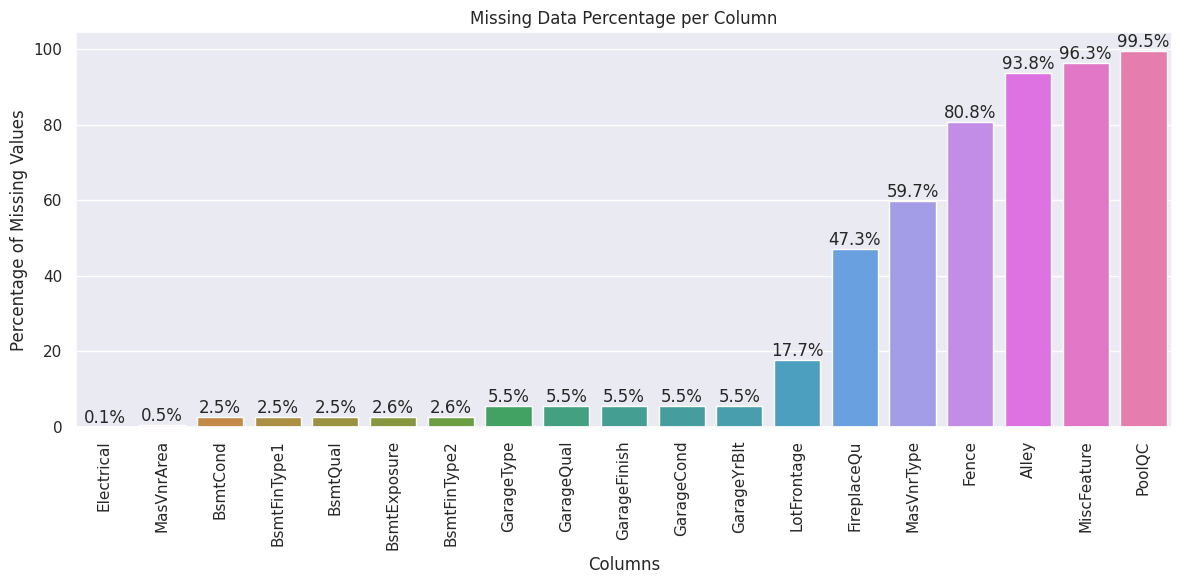

In [ ]:
# Видим, что есть 6 колонок, в которых более 45% пропущенных данных, лучшим решением будет удалить их
plot_missing_values(df)

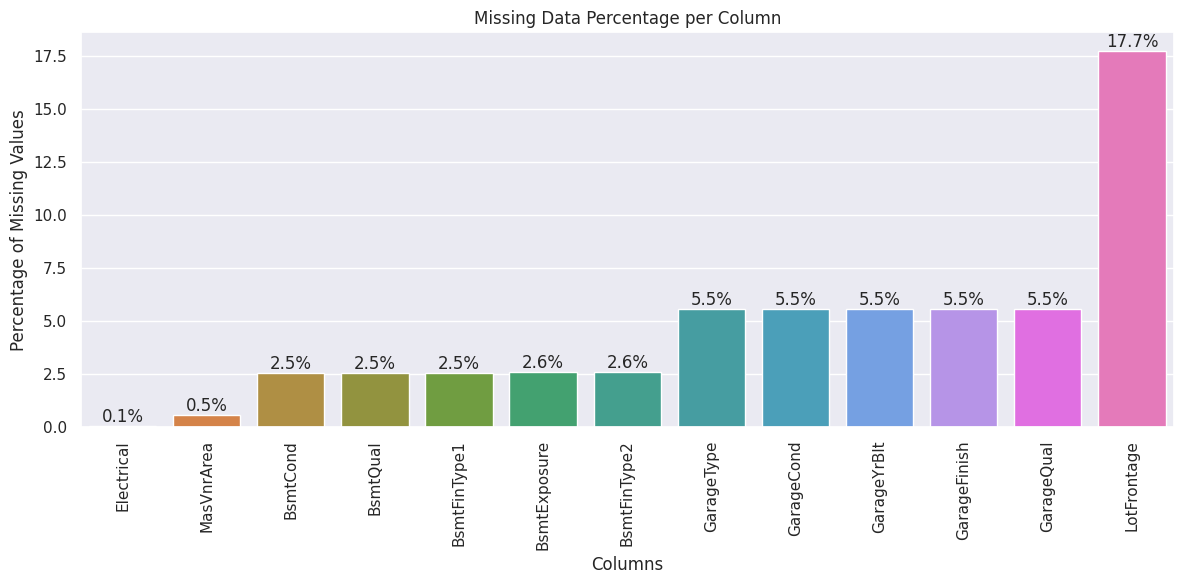

In [ ]:
# Удаляем признаки с большим кол-ом пропусков
df = df[df.columns[df.isna().mean() <= 0.45]]

# Осталось заполнить пропуски в колонках, где значений NaN не так много
plot_missing_values(df)

In [ ]:
# Разбиваем признаки на группы, чтобы далее применить к каждой группе опредленное заполнение пропусков

# Категориальные признаки, которые уже закодированы вручную (ordinal)
ordinal_encoded_cols = list(qual_cond_cols) + list(specific_mappings.keys())
ordinal_encoded_cols = [col for col in ordinal_encoded_cols if col in df.columns]

# Числовые, но только настоящие (исключаем закодированные категориальные)
real_numeric_cols = df.select_dtypes(include='number').columns.difference(ordinal_encoded_cols)

# Обычные строковые категориальные признаки
raw_categorical_cols = df.select_dtypes(include='object').columns

ordinal_encoded_cols, real_numeric_cols, raw_categorical_cols

(['ExterQual',
  'ExterCond',
  'BsmtQual',
  'BsmtCond',
  'HeatingQC',
  'KitchenQual',
  'GarageQual',
  'GarageCond',
  'LotShape',
  'Utilities',
  'LandSlope',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Functional',
  'GarageFinish',
  'PavedDrive'],
 Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
        'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
        'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
        'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
        'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
        'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
        'SalePrice', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF',
        'YearBuilt', 'YearRemodAdd', 'YrSold'],
       dtype='object'),
 Index(['MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood',
        'Condition1', 'Condition2', 'BldgType', 'Hous

In [ ]:
# Заполняем NaN в каждой группе опредленным образом

# Заполняем в числовых колонках Nan медианой
num_imputer = SimpleImputer(strategy='median')
df[real_numeric_cols] = num_imputer.fit_transform(df[real_numeric_cols])

# Заполняем NaN порядковых признаков -1
ordinal_inputer = SimpleImputer(strategy='constant', fill_value=-1)
df[ordinal_encoded_cols] = ordinal_inputer.fit_transform(df[ordinal_encoded_cols])

# Заполняем NaN категорильных признаков знаечнием 'Missing'
cat_inputer = SimpleImputer(strategy='constant', fill_value='Missing')
df[raw_categorical_cols] = cat_inputer.fit_transform(df[raw_categorical_cols])

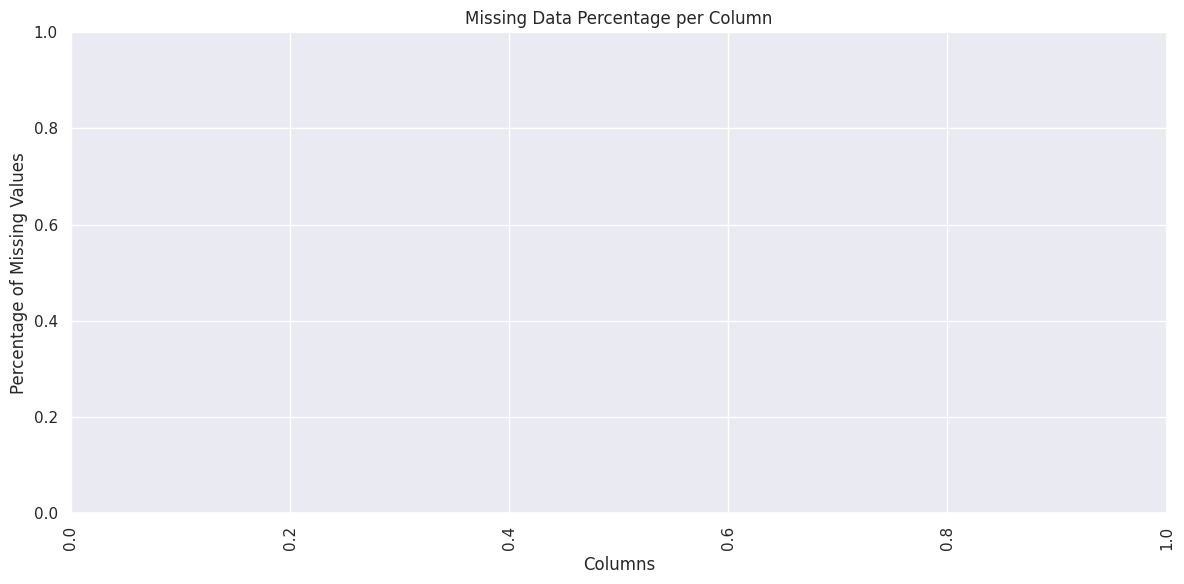

In [ ]:
# Видим, что мы избавились от всех пропусков в данных
plot_missing_values(df)

In [ ]:
# Так как в некоторых колонках были NaN, то они были типа float, поэтому теперь приводим явно их к int
df[ordinal_encoded_cols] = df[ordinal_encoded_cols].astype('int')

## Анализ целевой пемренной

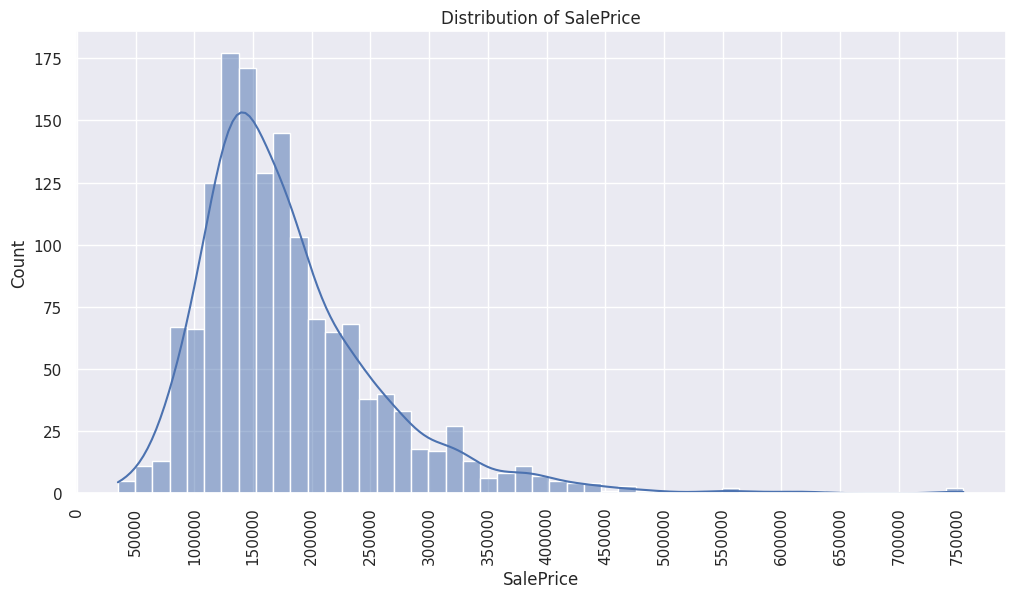

In [ ]:
# Строим гистограмму распрделения целевой перменной и видим, что она распрделена не равномерно
plt.figure(figsize=(12,6))
sns.histplot(data=df['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
min_val = 0
max_val_limit = 750000
step = 50000
xticks_values = np.arange(min_val, max_val_limit + step, step)

plt.xticks(xticks_values, rotation=90)
plt.show()

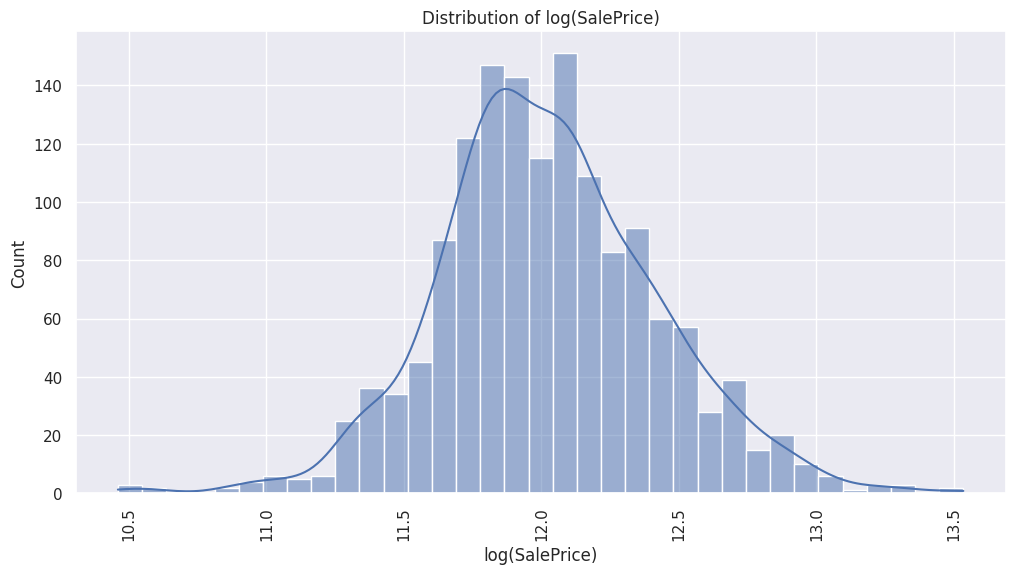

In [ ]:
# Замтеим, что если взять логарифм от ЦП, то распрделение будет намного ближе к равномерному
plt.figure(figsize=(12,6))
sns.histplot(data=np.log1p(df['SalePrice']), kde=True)
plt.title('Distribution of log(SalePrice)')

plt.xticks(rotation=90)
plt.xlabel('log(SalePrice)')
plt.show()

In [ ]:
df['SalePrice'] = np.log1p(df['SalePrice'])

<Axes: ylabel='SalePrice'>

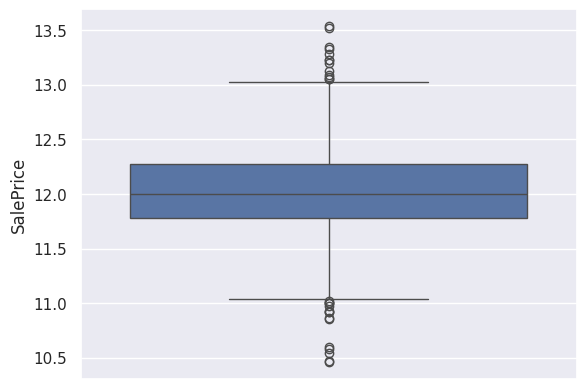

In [ ]:
# Посмотрим на расрпделение ЦП, видим, что есть выбросы
sns.boxplot(df['SalePrice'])

In [ ]:
# Проверям сколько процентов данных останется, если мы удалим выбросы, видим, что 98%, поэтому можем их удалить
q1 = df['SalePrice'].quantile(0.25)
q2 = df['SalePrice'].quantile(0.5)
q3 = df['SalePrice'].quantile(0.75)
IQR = q3 - q1
len(df[(df['SalePrice'] < q3 + 1.5 * IQR) & (df['SalePrice'] > q1 - 1.5 * IQR)]) / len(df) * 100

98.08219178082192

In [ ]:
# Удаляем выбросы из ЦП
df = df[(df['SalePrice'] < q3 + 1.5 * IQR) & (df['SalePrice'] > q1 - 1.5 * IQR)]

<Axes: ylabel='SalePrice'>

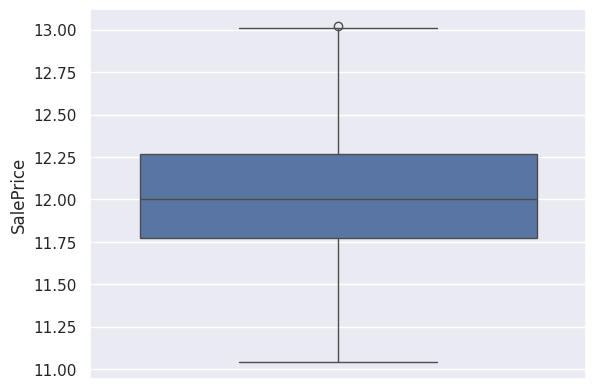

In [ ]:
# Видим, что выбросов на боксплот больше нет
sns.boxplot(df['SalePrice'])

## **Feature Engineering**

Сконструируем новые признаки, которые могут быть полезны и лучше коррелировать с ЦП.

In [ ]:
# Вспомогательный парметр для конструирования признаков
epsilon = 1e-6

In [ ]:
# Генерируем новые временные признаки

# Возраст дома
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
# Возраст с момента последнего ремонта
df['TimeSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
# Возраст гаража
df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']

In [ ]:
# Агрегация площадей и комнат

# Общая жилая площадь
df['TotalLivArea'] = df['GrLivArea'] + df['TotalBsmtSF']
# Общая площадь веранды/террас
df['TotalPorchSF'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
# Общее число ванных комнат
df['TotalBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'] + df['FullBath'] + 0.5 * df['HalfBath']
# Плотность застройки
df['LotDensity'] = df['LotArea'] / (df['LotFrontage'] + epsilon)

In [ ]:
# Качество и состояние

# Индекс качества экстерьера
df['ExtIndex'] = df['ExterCond'] + df['ExterQual']
# Индекс качества отопления и кондиционирования
df['HVACIndex'] = df['HeatingQC'] + df['CentralAir'].apply(lambda val: 1 if val=='Y' else 0)
# Индекс качества подвала
df['BsmtIndex'] = df['BsmtQual'] + df['BsmtCond'] + df['BsmtExposure'] + df['BsmtFinType1'] * df['BsmtFinSF1'] + df['BsmtFinType2'] * df['BsmtFinSF2']

In [ ]:
# Взаимодействия

# Качественно-скорректированная площадь
df['QualityAdjustedArea'] = df['TotalLivArea'] * df['OverallQual']
# Оценка износа
df['ConditionedAge'] = df['HouseAge'] * df['OverallCond']
# Отношение площади гаража к жилой площади
df['GarageProportion'] = df['GarageArea'] / (df['TotalLivArea'] + epsilon)

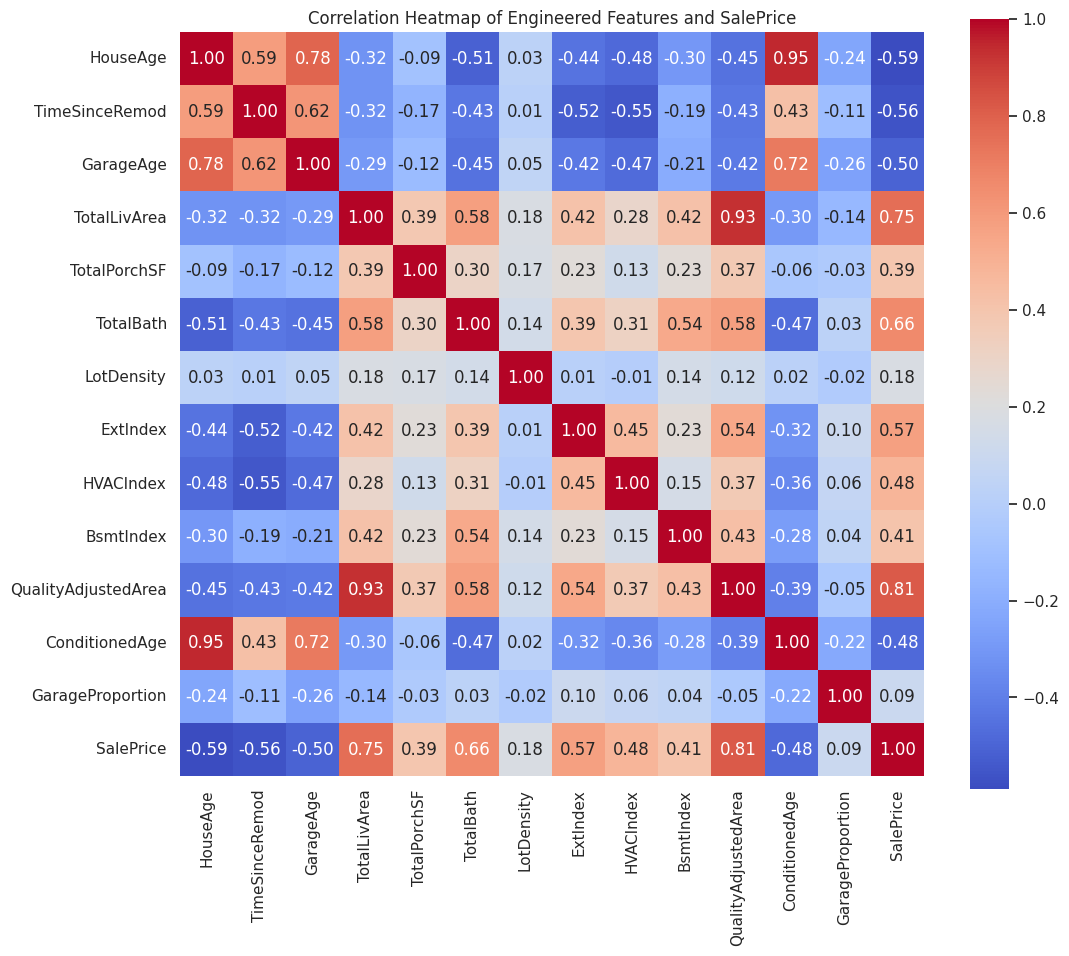

In [ ]:
# --- CORRELATION HEATMAP ---
new_feats = [
    'HouseAge', 'TimeSinceRemod', 'GarageAge', 'TotalLivArea',
    'TotalPorchSF', 'TotalBath', 'LotDensity', 'ExtIndex',
    'HVACIndex', 'BsmtIndex', 'QualityAdjustedArea',
    'ConditionedAge', 'GarageProportion'
]
corr = df[new_feats + ['SalePrice']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Heatmap of Engineered Features and SalePrice')
plt.show()

**Вывод по графику:** Сконструированные признаки, особенно QualityAdjustedArea, показывают сильную связь с целевой переменной SalePrice, что подтверждает их потенциальную полезность для моделирования. Признаки, связанные с возрастом и состоянием, ожидаемо имеют отрицательную корреляцию с ценой.

Correlation TotalLivArea vs SalePrice: 0.754
Correlation OverallQual vs SalePrice: 0.801
Correlation QualityAdjustedArea vs SalePrice: 0.815


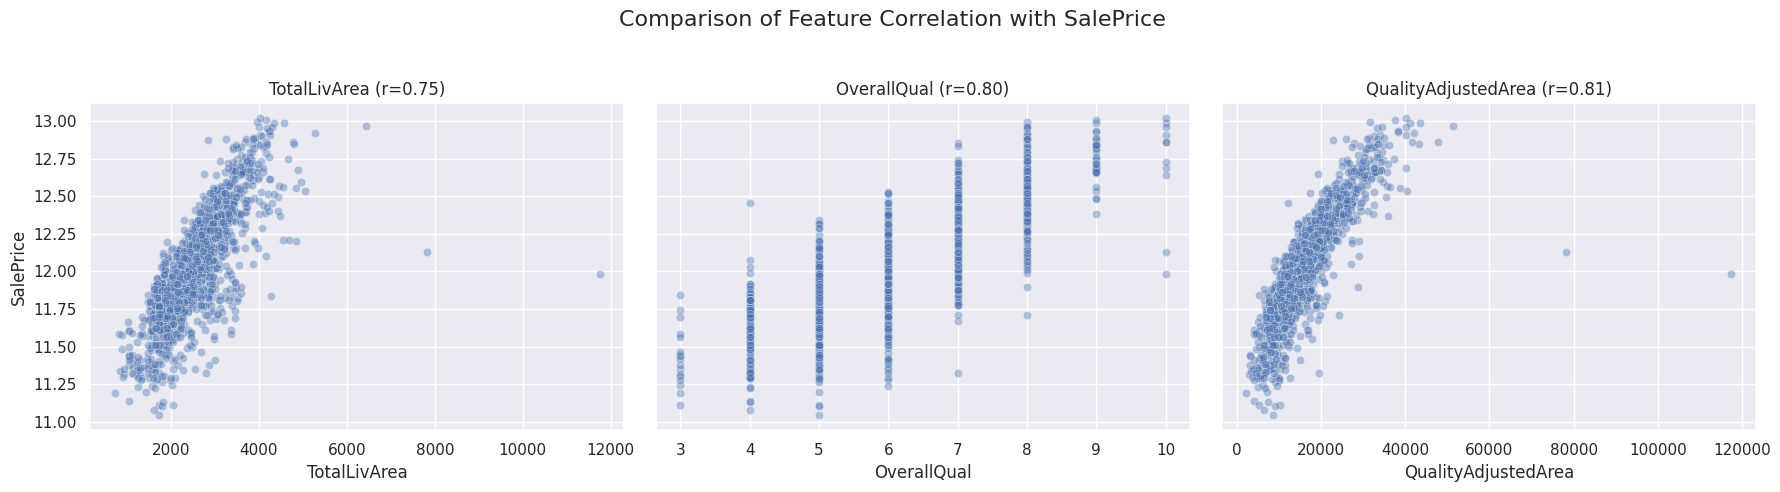

In [ ]:
# Считаем корреляции
corr_total = df['TotalLivArea'].corr(df['SalePrice'])
corr_qual = df['OverallQual'].corr(df['SalePrice'])
corr_combined = df['QualityAdjustedArea'].corr(df['SalePrice'])

print(f"Correlation TotalLivArea vs SalePrice: {corr_total:.3f}")
print(f"Correlation OverallQual vs SalePrice: {corr_qual:.3f}")
print(f"Correlation QualityAdjustedArea vs SalePrice: {corr_combined:.3f}")

# Рисуем все три графика на одной фигуре
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# TotalLivArea
sns.scatterplot(data=df, x='TotalLivArea', y='SalePrice', alpha=0.4, ax=axes[0])
axes[0].set_title(f'TotalLivArea (r={corr_total:.2f})')
axes[0].set_xlabel('TotalLivArea')
axes[0].set_ylabel('SalePrice')

# OverallQual
sns.scatterplot(data=df, x='OverallQual', y='SalePrice', alpha=0.4, ax=axes[1])
axes[1].set_title(f'OverallQual (r={corr_qual:.2f})')
axes[1].set_xlabel('OverallQual')
axes[1].set_ylabel('')

# QualityAdjustedArea
sns.scatterplot(data=df, x='QualityAdjustedArea', y='SalePrice', alpha=0.4, ax=axes[2])
axes[2].set_title(f'QualityAdjustedArea (r={corr_combined:.2f})')
axes[2].set_xlabel('QualityAdjustedArea')
axes[2].set_ylabel('')

# Общий заголовок
plt.suptitle('Comparison of Feature Correlation with SalePrice', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Вывод по графикам:** Сконструированный признак QualityAdjustedArea демонстрирует наилучшую линейную корреляцию с ценой продажи (SalePrice) (r=0.80) по сравнению с исходными признаками TotalLivArea (r=0.73) и OverallQual (r=0.78) по отдельности. Это говорит о том, что объединение информации о площади и качестве в один признак позволяет лучше предсказывать цену дома. Визуально, на третьем графике точки более плотно и линейно сгруппированы вдоль восходящей линии тренда.

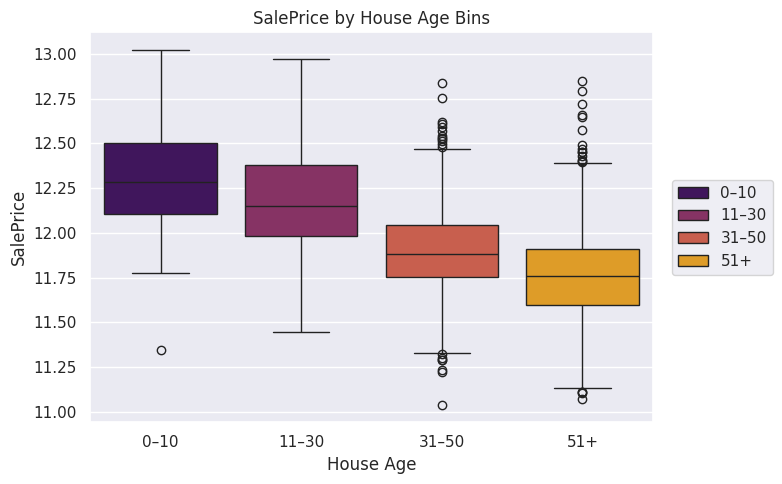

In [ ]:
# --- BOXPLOT: HouseAge (бинами) vs SalePrice ---
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x=pd.cut(df['HouseAge'], bins=[-1, 10, 30, 50, 100], labels=['0–10', '11–30', '31–50', '51+']),
    y='SalePrice',
    hue=pd.cut(df['HouseAge'], bins=[-1, 10, 30, 50, 100], labels=['0–10', '11–30', '31–50', '51+']),
    palette='inferno'
)
plt.title('SalePrice by House Age Bins')
plt.xlabel('House Age')
plt.ylabel('SalePrice')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()

**Вывод по графику:** Более новые дома (0-10 и 11-30 лет) в среднем продаются дороже, чем более старые дома (31-50 и 51+ лет). Наблюдается тенденция к снижению медианной цены продажи и общего диапазона цен с увеличением возраста дома. Для возрастных групп 31-50 лет и особенно 51+ лет наблюдается значительное количество выбросов (точек выше "верхнего уса"). Это означает, что существуют отдельные старые дома, которые продаются по ценам, значительно превышающим типичный диапазон цен для их возрастной категории. Это могут быть дома с особой архитектурой, историческим значением или расположенные в престижных старых районах.

## **Обработка категориальных признаков**

In [ ]:
# Посмотрим на кол-во уникальных знаечний в каждой категорильаной колонке
unique_cat_values = df[raw_categorical_cols].nunique()
unique_cat_values

MSZoning          5
Street            2
LandContour       4
LotConfig         5
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
Foundation        6
Heating           6
CentralAir        2
Electrical        6
GarageType        7
SaleType          9
SaleCondition     6
dtype: int64

Видим, что больше всего значений в *Neighborhood, Exterior1st, Exterior2nd*. Не хотелось бы плодить много признаков из них через OHE. Поэтому рассмотрим их подробнее.

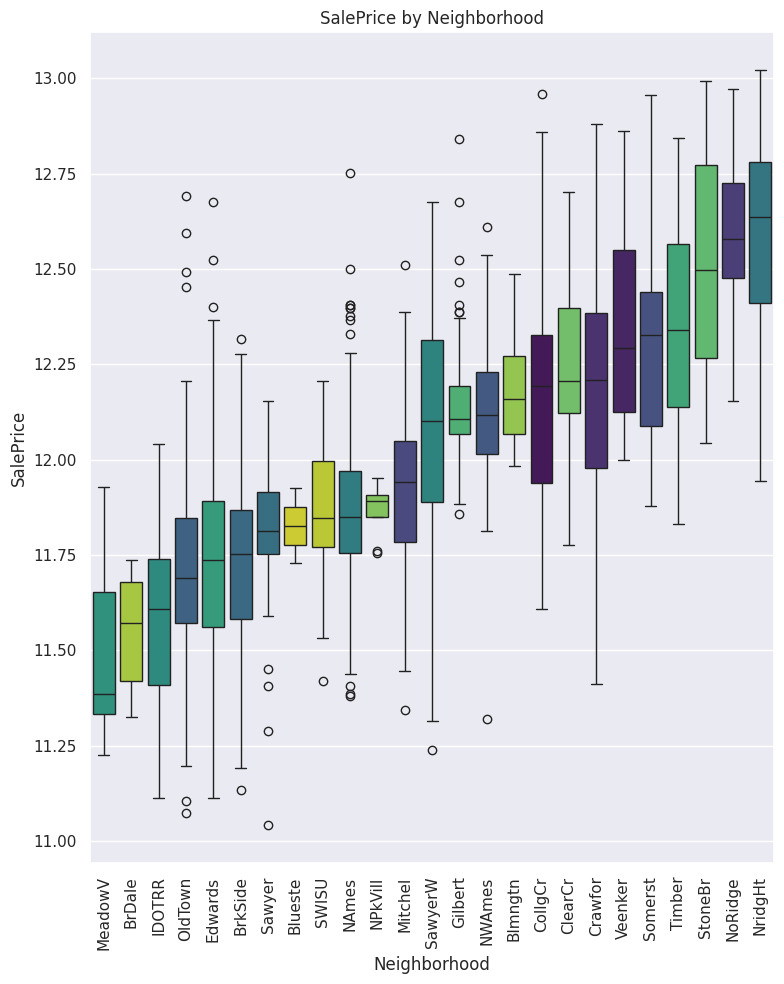

In [ ]:
# Строим распределние ЦП в зависимости от района
order_neighborhoods = df.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=True)

plt.figure(figsize=(8, 10))
sns.boxplot(data=df, x='Neighborhood', y='SalePrice', hue='Neighborhood', order=order_neighborhoods.index, palette='viridis')
plt.title('SalePrice by Neighborhood')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Вывод по графику:**
График демонстрирует, что стоимость недвижимости существенно зависит от района — медианные значения цены заметно различаются между районами, а в некоторых из них присутствуют значительные выбросы. Возможным решением мог бы быть переход от категориальной переменной к порядковой (ранговой), однако такой подход может привести к потере информации. Кроме того, наличие выбросов может исказить ранжирование и повлиять на интерпретацию.
Наиболее подходящим вариантом в данном случае представляется использование target encoding с сглаживанием, однако применять его буду только после разбиения данных на обучающую и тестовую выборки, чтобы избежать утечки информации о целевой переменной в тестовую выборку.

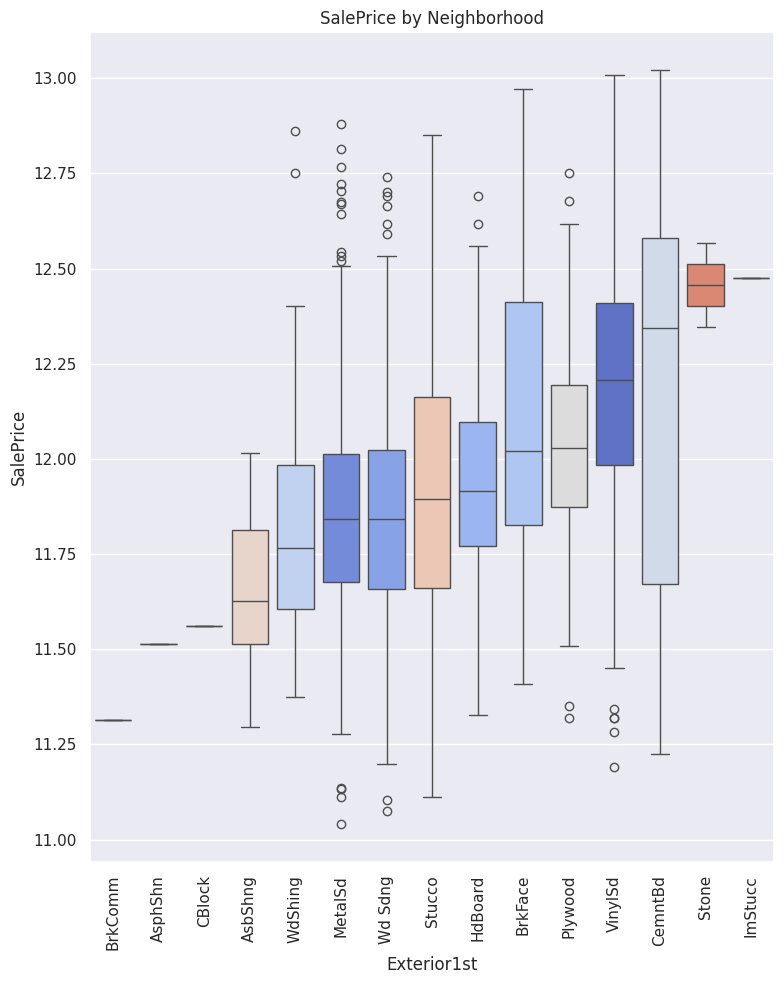

In [ ]:
# Строим аналогичный график для первого типа отделки
order_exterior1st = df.groupby('Exterior1st')['SalePrice'].median().sort_values(ascending=True)

plt.figure(figsize=(8, 10))
sns.boxplot(data=df, x='Exterior1st', y='SalePrice', hue='Exterior1st', order=order_exterior1st.index, palette='coolwarm')
plt.title('SalePrice by Neighborhood')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Выводы по графику:** Наблюдается четкая иерархия цен в зависимости от материала отделки. Медианный разброс у разных категорий очень разный. Кроме того, из общей картины выбиваются некоторые категории, так как в них слишком мало значений, их лучше всего удалить.
В целом, график подтверждает, что тип внешней отделки является важным фактором, влияющим на стоимость дома, и демонстрирует явную ценовую сегментацию по этому признаку.

In [ ]:
# Видим,что 4 значения в колонке Exterior1st встречются лишь единожды, поэтому их проще удалить
df = df[~df['Exterior1st'].isin(['AsphShn', 'CBlock', 'ImStucc', 'BrkComm'])]

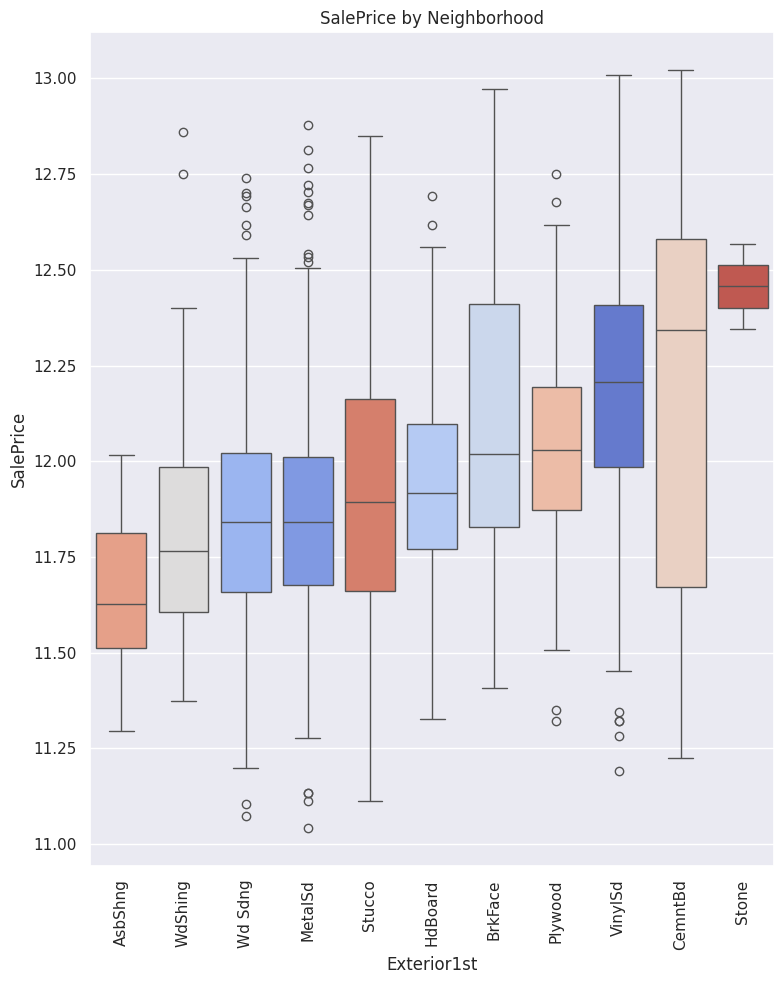

In [ ]:
# Строим аналогичный график для второго типа отделки
order_exterior1st = df.groupby('Exterior1st')['SalePrice'].median().sort_values(ascending=True)

plt.figure(figsize=(8, 10))
sns.boxplot(data=df, x='Exterior1st', y='SalePrice', hue='Exterior1st', order=order_exterior1st.index, palette='coolwarm')
plt.title('SalePrice by Neighborhood')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

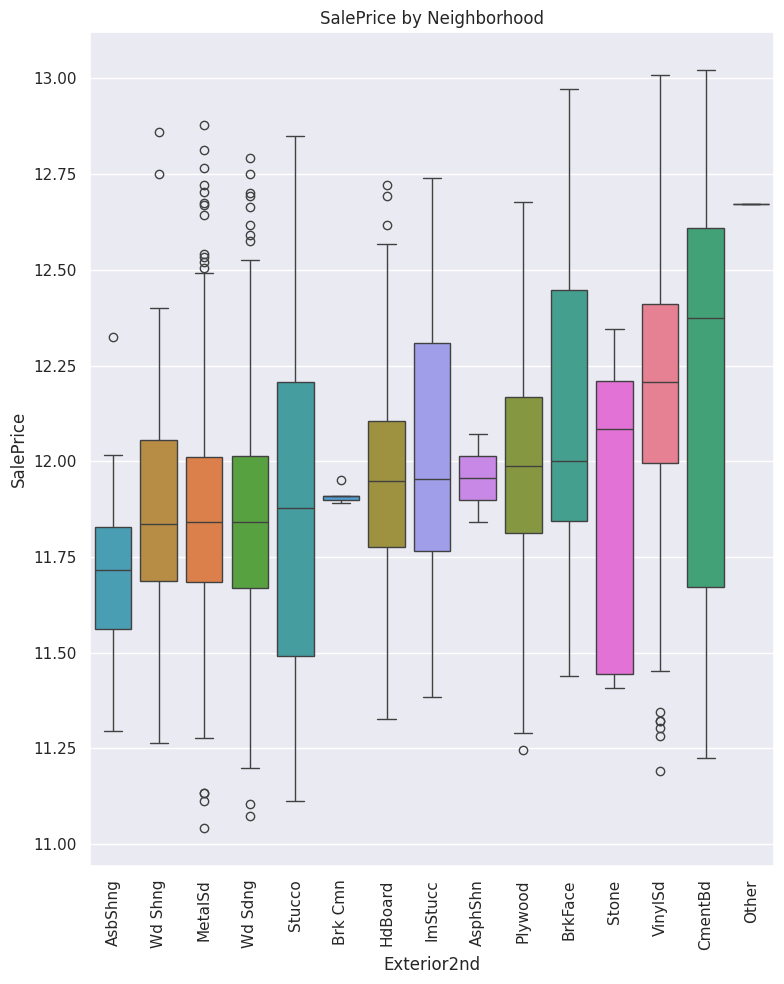

In [ ]:
order_exterior2nd = df.groupby('Exterior2nd')['SalePrice'].median().sort_values(ascending=True)

plt.figure(figsize=(8, 10))
sns.boxplot(data=df, x='Exterior2nd', y='SalePrice', hue='Exterior2nd', order=order_exterior2nd.index, palette='husl')
plt.title('SalePrice by Neighborhood')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Вывод по графику:**
Здесь тоже прослеживается чёткая иерархия, хотя присутсвуют выбросы и разброс внутри категорий очень разный. И есть одна категория "Other", в которой судя по всему один объект, его можно удалить.

In [ ]:
df = df[~(df['Exterior2nd'] == 'Other')]

**Вывод по анализу категорильных перменных:** Были рассматорены признаки, которые имели больше всего знаечний (Neighborhood, Exterior1st, Exterior2nd). Для каждого из признаков была выявлена зависимость между ним и целевой перменной. Наболее оптимальный способ кодирования для этих признаков - это Target Encoder со сглаживанием, но применён он будет после разбиения данных на обучающую и тестовую выборку, чтобы информация о целевой перменной в тестовой выборке не просочилась в признаки. В остальных категорильных признаках значений не так уже много 2-9, поэтому их можно спокойно обработать через OHE.

In [ ]:
# Получили, что после применения OHE получится 102 дополнительных колонки, что вполне допутсимо для градиентного бустинга
unique_cat_values.sum() - unique_cat_values['Neighborhood'] - unique_cat_values['Exterior1st'] - unique_cat_values['Exterior2nd']

np.int64(102)

In [ ]:
# Запоминаем отдельно колонки для Target Encoder
target_encoded_cols = ['Neighborhood', 'Exterior1st', 'Exterior2nd']
# Запоминаем обычные категорильные колонки для OHE
raw_categorical_cols = raw_categorical_cols.difference(target_encoded_cols)

In [ ]:
# Преобрзауем остальные признаки через OHE
df = pd.get_dummies(df, columns=raw_categorical_cols, drop_first=True)

In [ ]:
# Кол-во признаков, которые есть на данный момент: 155
df.shape[1]

155

# **Обучение моделей**

## **Подготовка данных**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from typing import Dict, List, Union
from sklearn.model_selection import KFold
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
import optuna
from sklearn.model_selection import cross_val_score
import optuna.visualization as vis
import plotly.io as pio
import pickle
import shap

In [ ]:
# Подготовка списков признаков, которые были составлены при EDA
real_numeric_cols = ['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MSSubClass',
 'MasVnrArea',
 'MiscVal',
 'MoSold',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'YrSold']

raw_categorical_cols = ['BldgType',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'Foundation',
 'GarageType',
 'Heating',
 'HouseStyle',
 'LandContour',
 'LotConfig',
 'MSZoning',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Street']

target_encoded_cols = ['Neighborhood', 'Exterior1st', 'Exterior2nd']

ordinal_encoded_cols = ['ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'HeatingQC',
 'KitchenQual',
 'GarageQual',
 'GarageCond',
 'LotShape',
 'Utilities',
 'LandSlope',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Functional',
 'GarageFinish',
 'PavedDrive']

all_cols = real_numeric_cols + raw_categorical_cols + target_encoded_cols + ordinal_encoded_cols

In [ ]:
# Функция для обработки исходных данных (актуальна только для train.csv)
def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Логарифмирование целевой переменной
    df['SalePrice'] = np.log1p(df['SalePrice'])

    # Удаление выбросов по IQR
    q1 = df['SalePrice'].quantile(0.25)
    q3 = df['SalePrice'].quantile(0.75)
    iqr = q3 - q1
    df = df[(df['SalePrice'] > q1 - 1.5 * iqr) & (df['SalePrice'] < q3 + 1.5 * iqr)]

    # Удаление редких категорий в Exterior1st
    bad_exterior1st = ['AsphShn', 'CBlock', 'ImStucc', 'BrkComm']
    df = df[~df['Exterior1st'].isin(bad_exterior1st)]

    # Удаление строк, где Exterior2nd == 'Other'
    df = df[df['Exterior2nd'] != 'Other']

    return df

In [ ]:
# Трансформер для кодирования некоторых категорильных признаков в порядковые
class OrdinalEncoderByMap(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Общая шкала качества/состояния
        qual_cond_map = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

        # Индивидуальные маппинги
        self.mappings = {
            # Признаки с общей шкалой
            'ExterQual': qual_cond_map,
            'ExterCond': qual_cond_map,
            'BsmtQual': qual_cond_map,
            'BsmtCond': qual_cond_map,
            'HeatingQC': qual_cond_map,
            'KitchenQual': qual_cond_map,
            # 'FireplaceQu': qual_cond_map,
            'GarageQual': qual_cond_map,
            'GarageCond': qual_cond_map,

            # Индивидуальные маппинги
            # 'Alley': {'NA': 0, 'Grvl': 1, 'Pave': 2},
            'LotShape': {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4},
            'Utilities': {'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4},
            'LandSlope': {'Sev': 1, 'Mod': 2, 'Gtl': 3},
            'BsmtExposure': {'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
            'BsmtFinType1': {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
            'BsmtFinType2': {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
            'Functional': {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7},
            'GarageFinish': {'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
            'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
            # 'PoolQC': {'NA': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
            # 'Fence': {'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
        }

        # Сохраняем список колонок
        self.columns = list(self.mappings.keys())

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            if col in X.columns:
                X[col] = X[col].map(self.mappings[col]).fillna(-1)
        return X


In [ ]:
# Трансформер для создания новых признаков, составленных при EDA
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, epsilon=1e-6):
        self.epsilon = epsilon
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['HouseAge'] = X['YrSold'] - X['YearBuilt']
        X['TimeSinceRemod'] = X['YrSold'] - X['YearRemodAdd']
        X['GarageAge'] = X['YrSold'] - X['GarageYrBlt']
        X['TotalLivArea'] = X['GrLivArea'] + X['TotalBsmtSF']
        X['TotalPorchSF'] = (
            X['WoodDeckSF'] + X['OpenPorchSF'] + X['EnclosedPorch']
            + X['3SsnPorch'] + X['ScreenPorch']
        )
        X['TotalBath'] = (
            X['BsmtFullBath'] + 0.5 * X['BsmtHalfBath']
            + X['FullBath'] + 0.5 * X['HalfBath']
        )
        X['LotDensity'] = X['LotArea'] / (X['LotFrontage'] + self.epsilon)
        X['QualityAdjustedArea'] = X['TotalLivArea'] * X['OverallQual']
        X['ConditionedAge'] = X['HouseAge'] * X['OverallCond']
        X['GarageProportion'] = X['GarageArea'] / (X['TotalLivArea'] + self.epsilon)
        return X

In [ ]:
# Трансформер для кодирования категорильных переменных через Traget Encoder с использованием сглаженного
# среднего и кросс-валидации
class KFoldMeanTargetEncoderSmoothing(BaseEstimator, TransformerMixin):
  def __init__(self, n_splits: int = 5, shuffle: bool = True,
               random_state: int = 42, noise_level: float = 0.0,
               prior: Union[float, str] = 'global_mean', C: float = 10.0) -> None:
    self.n_splits: int = n_splits
    self.shuffle: bool = shuffle
    self.random_state: bool = random_state
    self.target_means: Dict[str, Dict] = {}
    self.fold_means: Dict[str, List[Dict]] = {}
    self.global_mean: float = None
    self.noise_level: float = noise_level
    self.prior: Union[float, str] = prior
    self.C: float = C

  def fit(self, X: pd.DataFrame, y: pd.Series) -> "KFoldMeanTargetEncoderSmoothing":
    self.cat_cols = X.columns.tolist()
    X_with_target = X.copy()
    X_with_target['target'] = y
    self.global_mean = y.mean()

    if self.prior == 'global_mean':
      prior_value = self.global_mean
    elif isinstance(self.prior, (int, float)):
      prior_value = float(self.prior)
    else:
      raise ValueError("Invalid prior value.  Must be 'global_mean' or a number.")

    for col in self.cat_cols:
      self.fold_means[col] = []
      self.target_means[col] = {}

    kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)

    for train_idx, _ in kf.split(X_with_target):
      X_train_fold = X_with_target.iloc[train_idx]

      for col in self.cat_cols:

        def smoothed_mean_agg(series):
          return (series.sum() + self.C * prior_value) / (series.count() + self.C)

        fold_means_dict = X_train_fold.groupby(col)['target'].agg(smoothed_mean_agg).to_dict()

        self.fold_means[col].append(fold_means_dict)

    for col in self.cat_cols:
      all_keys = set()
      for fold_dict in self.fold_means[col]:
        all_keys.update(fold_dict.keys())

      for key in all_keys:
        values = [fold_dict.get(key) for fold_dict in self.fold_means[col] if key in fold_dict]

        if values:
          self.target_means[col][key] = np.mean(values)
        else:
          self.target_means[col][key] = self.global_mean

    return self

  def transform(self, X: pd.DataFrame) -> pd.DataFrame:
    X_transformed = X.copy()

    for col in self.cat_cols:
      mapping = self.target_means[col]
      X_transformed[col] = X_transformed[col].map(mapping).fillna(self.global_mean)
      noise = np.random.normal(loc=0, scale=self.noise_level, size=X_transformed[col].shape)
      X_transformed[col] += noise

    return X_transformed

In [ ]:
# Составление пайплайнов для разных видов колонок
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

ohe_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

ordinal_pipeline = Pipeline([
    ('ordinal', OrdinalEncoderByMap()),
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1))
])

target_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    # ('target', KFoldMeanTargetEncoderSmoothing(noise_level=0.01, C=5.0))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, real_numeric_cols),
    ('ord', ordinal_pipeline, ordinal_encoded_cols),
    ('ohe', ohe_pipeline, raw_categorical_cols),
    ('tgt', target_pipeline, target_encoded_cols)
])

In [ ]:
# Снова загружаем данные, чтобы прогнать их через ColumnTransformer
df = pd.read_csv('train.csv').set_index('Id')[all_cols + ['SalePrice']]
df = preprocess_dataframe(df)

In [ ]:
# Разделяем данные на тестовую и тренировочную выборки
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Превдарительно применяем к некоторым колонкам Target Encoder, чтобы данные не утекали в процессе обучения
target_encoder = KFoldMeanTargetEncoderSmoothing(noise_level=0.01, C=5.0)
X_train[target_encoded_cols] = target_encoder.fit_transform(X_train[target_encoded_cols], y_train)
X_test[target_encoded_cols] = target_encoder.transform(X_test[target_encoded_cols])

## **Обучение моделей без подбора параметров**

Для начала проверим насколько хорошо справляются
 с задачей модели градиентного бустинга с парамтерами по умолчанию.

In [ ]:
# Создаём словарь, где будут храниться результаты всех экспериментов
results = {}

In [ ]:
# Функция, которая считает все интересующие нас метрики
def calculate_metrics(y_true_log1p, y_pred_log1p):
  metrics = {}
  y_true, y_pred = np.expm1x(y_true_log1p), np.expm1x(y_pred_log1p)
  metrics['RMSLE'] = np.round(np.sqrt(mean_squared_error(y_true_log1p, y_pred_log1p)), 3)
  metrics['R2'] = np.round(r2_score(y_true, y_pred), 3)
  metrics['MAE'] = np.round(mean_absolute_error(y_true, y_pred), 3)
  return metrics

In [ ]:
# Функция для тренировки модели, в случае если передан параметр tune, то оптимизирует модель через optuna
def train_model(results, model, model_name, X_train, y_train, X_test, y_test, tune=False, n_trials=30, param_spaces=None):
    if tune:
        model = optimize_with_optuna(model, model_name, X_train, y_train, n_trials, param_spaces)

    start_time = time.perf_counter()
    model.fit(X_train, y_train)
    end_time = time.perf_counter()
    training_time = end_time - start_time

    y_pred = model.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    results[model_name] = {**metrics, 'Time(s)': training_time}
    return model

In [ ]:
# Функция создаёт словарь с моделями с параметрами по умолчанию с заданными ключами
def get_models(keys, param_grids=None):
  # Для Gradient Boosting
  model_gb = Pipeline([
      ("preprocessing", preprocessor),
      ("regressor", GradientBoostingRegressor(random_state=42))
  ])

  # Для XGBoost
  model_xgb = Pipeline([
      ("preprocessing", preprocessor),
      ("regressor", xgb.XGBRegressor(random_state=42, verbosity=0))
  ])

  # Для LightGBM
  model_lgbm = Pipeline([
      ("preprocessing", preprocessor),
      ("regressor", lgb.LGBMRegressor(random_state=42))
  ])

  # Для CatBoost
  model_cat = Pipeline([
      ("preprocessing", preprocessor),
      ("regressor", cb.CatBoostRegressor(random_state=42, verbose=0))
  ])
  if param_grids:
    models = {keys[0]: (model_gb, param_grids[0]), keys[1]: (model_xgb, param_grids[1]), keys[2]: (model_lgbm, param_grids[2]), keys[3]: (model_cat, param_grids[3])}
  else:
    models = {keys[0]: model_gb, keys[1]: model_xgb, keys[2]: model_lgbm, keys[3]: model_cat}
  return models

In [ ]:
# Тренрируем каждую модель и запоминаем результаты в results
models = get_models(['Gradient Boosting', 'XGBoost', 'LightGBM', 'CatBoost'])

for model_name, model in models.items():
  models[model_name] = train_model(results, model, model_name, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3819
[LightGBM] [Info] Number of data points in the train set: 1141, number of used features: 98
[LightGBM] [Info] Start training from score 12.030403


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Выводим results в формате DataFrame
pd.DataFrame(index=results.keys(), data=results.values())

RMSLE     R2        MAE   Time(s)
Gradient Boosting  0.112  0.897  14696.866  1.084310
XGBoost            0.127  0.856  16788.012  0.545149
LightGBM           0.118  0.879  15284.075  0.249530
CatBoost           0.110  0.897  14100.747  5.673659

Как видим, даже без подбора параметров все бустинги показывают достойный реузльтат. Лучше всех выглядит CatBoost.

## **Оптимизация с помоью Grid Search**

In [ ]:
# Словари с параметрами для Grid Search
param_grid_gb = {
    'regressor__n_estimators': [50, 100],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5],
    'regressor__subsample': [0.8, 1.0]
}

param_grid_xgb = {
    'regressor__n_estimators': [50, 100],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}

param_lgbm = {
    'regressor__n_estimators': [50, 100],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5, -1],
    'regressor__num_leaves': [15, 31],
    'regressor__subsample': [0.8, 1.0]
}

param_grid_cat = {
    'regressor__iterations': [100, 300],
    'regressor__learning_rate': [0.03, 0.1],
    'regressor__depth': [4, 6],
    'regressor__l2_leaf_reg': [1, 3]
}

param_grids = [param_grid_gb, param_grid_xgb, param_lgbm, param_grid_cat]


In [ ]:
# Функция, реализующая Grid Search
def grid_search(results, model, model_name, param_grid, X_train, y_train, X_test, y_test):
  gs = GridSearchCV(model, param_grid, cv=5)
  gs.fit(X_train, y_train)
  best_model = gs.best_estimator_
  best_model = train_model(results, best_model, model_name, X_train, y_train, X_test, y_test)
  return best_model

In [ ]:
pd.DataFrame(index=results.keys(), data=results.values())

RMSLE     R2        MAE   Time(s)
Gradient Boosting     0.112  0.897  14696.866  1.084310
XGBoost               0.127  0.856  16788.012  0.545149
LightGBM              0.118  0.879  15284.075  0.249530
CatBoost              0.110  0.897  14100.747  5.673659
Gradient Boosting GS  0.113  0.898  14394.267  0.897465
XGBoost GS            0.119  0.882  15415.569  0.173062
LightGBM GS           0.120  0.877  15190.949  0.116738
CatBoost GS           0.111  0.896  14169.126  1.813066

## **Оптимизация моделей с помощью Optuna**

Попробуем теперь подобрать оптимальные параметры с помощью библиотеки Optuna - это мощная библиотека на Python для автоматической оптимизации гиперпараметров моделей машинного обучения и других задач оптимизации. Она помогает находить лучшие комбинации параметров, минимизируя или максимизируя целевую функцию, в нашем случае RMSLE.

In [ ]:
# Функция, для оптимизации с помощью Optuna
def optimize_with_optuna(model_pipeline, model_name,
                         X_train, y_train,
                         n_trials, param_spaces):
    """
    Универсальная функция для Optuna с:
     - лог-параметрами,
     - pruning callbacks,
     - возвратом положительного RMSLE,
     - суженными диапазонами.
    """
    space = param_spaces[model_name]
    preprocessing = model_pipeline.named_steps["preprocessing"]
    base_regressor = model_pipeline.named_steps["regressor"]

    def objective(trial):
        # Собираем параметры из словаря space
        params = {}
        for pname, cfg in space.items():
            kind = cfg[0]
            if kind == "int":
                params[pname] = trial.suggest_int(pname, cfg[1], cfg[2])
            elif kind == "float":
                params[pname] = trial.suggest_float(pname, cfg[1], cfg[2])
            elif kind == "float_log":
                params[pname] = trial.suggest_float(pname, cfg[1], cfg[2], log=True)
            elif kind == "categorical":
                params[pname] = trial.suggest_categorical(pname, cfg[1])

        # Клонируем и настраиваем регрессор
        reg = clone(base_regressor)
        if "n_jobs" in reg.get_params():
            params["n_jobs"] = -1
        reg.set_params(**params, random_state=42)

        # Собираем пайплайн
        pipeline = Pipeline([
            ("preprocessing", preprocessing),
            ("regressor", reg)
        ])

        # cross_val_score возвращает neg_root_mean_squared_error
        neg_rmsles = cross_val_score(
            pipeline, X_train, y_train,
            scoring="neg_root_mean_squared_error",
            cv=5,
            n_jobs=-1
        )
        rmsle = -neg_rmsles.mean()
        return rmsle

    # Запуск оптимизации
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    # Сохраняем результаты
    best_params = study.best_params
    best_rmsle  = study.best_value

    optuna_studies[model_name]   = study
    best_params_dict[model_name] = best_params
    best_rmsle_dict[model_name]  = best_rmsle

    # Собираем итоговый pipeline
    best_reg = clone(base_regressor)
    best_reg.set_params(**best_params, random_state=42)
    optimized_pipeline = Pipeline([
        ("preprocessing", preprocessing),
        ("regressor", best_reg)
    ])

    print(f"[{model_name}] best RMSLE = {best_rmsle:.5f}")
    print(f"[{model_name}] best params: {best_params}")

    return optimized_pipeline

In [ ]:
# Описание пространства поиска для каждой модели
param_spaces = {
    'Gradient Boosting Opt': {
        "n_estimators":      ("int", 100, 300),
        "learning_rate":     ("float_log", 0.01, 0.1),
        "max_depth":         ("int", 3, 7),
        "min_samples_leaf":  ("int", 1, 20),
        "subsample":         ("float", 0.7, 1.0),
        "max_features":      ("categorical", [None, 'sqrt', 'log2']),
        "loss":              ("categorical", ['squared_error', 'absolute_error', 'huber']),
    },
    'XGBoost Opt': {
        "n_estimators":      ("int", 100, 300),
        "learning_rate":     ("float_log", 0.01, 0.1),
        "max_depth":         ("int", 3, 7),
        "subsample":         ("float", 0.7, 1.0),
        "colsample_bytree":  ("float", 0.6, 0.9),
        "gamma":             ("float", 0.0, 5.0),
        "reg_alpha":         ("float_log", 1e-3, 10.0),
        "reg_lambda":        ("float_log", 1e-3, 10.0),
        "min_child_weight":  ("int", 1, 20),
        "tree_method":       ("categorical", ["auto", "hist"]),
    },
    'LightGBM Opt': {
        "n_estimators":      ("int", 100, 300),
        "learning_rate":     ("float_log", 0.01, 0.1),
        "max_depth":         ("int", 3, 7),
        "num_leaves":        ("int", 20, 64),
        "subsample":         ("float", 0.7, 1.0),
        "colsample_bytree":  ("float", 0.6, 0.9),
        "reg_alpha":         ("float_log", 1e-3, 10.0),
        "reg_lambda":        ("float_log", 1e-3, 10.0),
    },
    'CatBoost Opt': {
        "iterations":        ("int", 100, 300),
        "learning_rate":     ("float_log", 0.01, 0.1),
        "depth":             ("int", 3, 7),
        "l2_leaf_reg":       ("float", 1.0, 10.0),
        "bagging_temperature": ("float", 0.0, 1.0),
        "random_strength":   ("float", 1.0, 20.0),
        "border_count":      ("int", 32, 128),
    },
}

In [ ]:
# Создаём словари для хранения результатов
optuna_studies    = {}
best_params_dict  = {}
best_rmsle_dict   = {}

In [ ]:
# Запускаем оптимизацию моделей и сохраняем их
models_opt = get_models(['Gradient Boosting Opt', 'XGBoost Opt', 'LightGBM Opt', 'CatBoost Opt'])

for model_name, model in models_opt.items():
    models_opt[model_name] = train_model(results, model, model_name, X_train, y_train, X_test, y_test, tune=True, n_trials=30, param_spaces=param_spaces)

[I 2025-05-12 14:30:14,199] A new study created in memory with name: no-name-802640ee-0337-47fd-93f5-17dba7cfd3b4


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-05-12 14:30:17,354] Trial 0 finished with value: 0.13623074647432237 and parameters: {'n_estimators': 165, 'learning_rate': 0.03603820800338636, 'max_depth': 3, 'min_samples_leaf': 19, 'subsample': 0.8270042047880191, 'max_features': 'log2', 'loss': 'absolute_error'}. Best is trial 0 with value: 0.13623074647432237.
[I 2025-05-12 14:30:28,529] Trial 1 finished with value: 0.13323213236141057 and parameters: {'n_estimators': 271, 'learning_rate': 0.014104417026020822, 'max_depth': 7, 'min_samples_leaf': 13, 'subsample': 0.8499775334717731, 'max_features': 'log2', 'loss': 'absolute_error'}. Best is trial 1 with value: 0.13323213236141057.
[I 2025-05-12 14:30:31,816] Trial 2 finished with value: 0.13196880278019427 and parameters: {'n_estimators': 251, 'learning_rate': 0.010703833455030945, 'max_depth': 5, 'min_samples_leaf': 9, 'subsample': 0.7591844054062444, 'max_features': 'sqrt', 'loss': 'squared_error'}. Best is trial 2 with value: 0.13196880278019427.
[I 2025-05-12 14:30:43

[I 2025-05-12 14:33:08,074] A new study created in memory with name: no-name-45ab0cfe-db6b-46dd-bef6-fcefe0e22db1


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-05-12 14:33:09,110] Trial 0 finished with value: 0.16466442658328329 and parameters: {'n_estimators': 166, 'learning_rate': 0.027856189954720712, 'max_depth': 6, 'subsample': 0.9813431060483542, 'colsample_bytree': 0.6701458626451998, 'gamma': 2.188623460045209, 'reg_alpha': 0.0195546564682829, 'reg_lambda': 0.4687592040413472, 'min_child_weight': 16, 'tree_method': 'auto'}. Best is trial 0 with value: 0.16466442658328329.
[I 2025-05-12 14:33:10,121] Trial 1 finished with value: 0.15980347134415648 and parameters: {'n_estimators': 253, 'learning_rate': 0.099617977577437, 'max_depth': 7, 'subsample': 0.9057604318270212, 'colsample_bytree': 0.6691882275246197, 'gamma': 1.8919518253133933, 'reg_alpha': 0.007244059602767039, 'reg_lambda': 5.380682591925686, 'min_child_weight': 4, 'tree_method': 'hist'}. Best is trial 1 with value: 0.15980347134415648.
[I 2025-05-12 14:33:11,376] Trial 2 finished with value: 0.17565056599885862 and parameters: {'n_estimators': 203, 'learning_rate': 

[I 2025-05-12 14:33:55,745] A new study created in memory with name: no-name-ac259cb9-96cc-43b0-9352-4a469024e78a


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-05-12 14:33:57,358] Trial 0 finished with value: 0.12021800390992417 and parameters: {'n_estimators': 231, 'learning_rate': 0.022499369870351175, 'max_depth': 4, 'num_leaves': 39, 'subsample': 0.8943635399494685, 'colsample_bytree': 0.8817294095962064, 'reg_alpha': 0.0023040769695754156, 'reg_lambda': 1.3286909207419728}. Best is trial 0 with value: 0.12021800390992417.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-05-12 14:33:58,916] Trial 1 finished with value: 0.1204494319440191 and parameters: {'n_estimators': 292, 'learning_rate': 0.07163636128411183, 'max_depth': 5, 'num_leaves': 63, 'subsample': 0.7842685835901674, 'colsample_bytree': 0.8097139500193942, 'reg_alpha': 0.005297732975476672, 'reg_lambda': 0.004338873107621491}. Best is trial 0 with value: 0.12021800390992417.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-05-12 14:34:02,946] Trial 4 finished with value: 0.1408942077114728 and parameters: {'n_estimators': 273, 'learning_rate': 0.010784624876847488, 'max_depth': 5, 'num_leaves': 63, 'subsample': 0.8231407164923095, 'colsample_bytree': 0.6556444032942282, 'reg_alpha': 1.6404969633220121, 'reg_lambda': 1.8387384489333092}. Best is trial 2 with value: 0.11898578778560054.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-05-12 14:34:04,416] Trial 5 finished with value: 0.1192894237330997 and parameters: {'n_estimators': 221, 'learning_rate': 0.033353113191796964, 'max_depth': 5, 'num_leaves': 56, 'subsample': 0.7125549584245894, 'colsample_bytree': 0.7588406408376269, 'reg_alpha': 0.003839304183796039, 'reg_lambda': 0.6494629129198003}. Best is trial 2 with value: 0.11898578778560054.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, nu

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-05-12 14:34:06,946] Trial 7 finished with value: 0.12667883239209715 and parameters: {'n_estimators': 247, 'learning_rate': 0.017094021098759217, 'max_depth': 3, 'num_leaves': 58, 'subsample': 0.7271578826822538, 'colsample_bytree': 0.6492641150070986, 'reg_alpha': 0.03315646591408175, 'reg_lambda': 3.9028089352321276}. Best is trial 2 with value: 0.11898578778560054.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-05-12 14:34:08,813] Trial 8 finished with value: 0.12116770026207264 and parameters: {'n_estimators': 191, 'learning_rate': 0.0989077089580992, 'max_depth': 5, 'num_leaves': 41, 'subsample': 0.9457451171265812, 'colsample_bytree': 0.7309303989239478, 'reg_alpha': 0.013388008206341324, 'reg_lambda': 0.0059303669481667294}. Best is trial 2 with value: 0.11898578778560054.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-05-12 14:34:22,591] Trial 17 finished with value: 0.11879402375676595 and parameters: {'n_estimators': 205, 'learning_rate': 0.024617234146879302, 'max_depth': 7, 'num_leaves': 31, 'subsample': 0.8685458027874466, 'colsample_bytree': 0.6214156772218555, 'reg_alpha': 0.0616160741438741, 'reg_lambda': 0.23690878408399896}. Best is trial 16 with value: 0.11776746778588021.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-05-12 14:34:27,502] Trial 20 finished with value: 0.1339358831766461 and parameters: {'n_estimators': 230, 'learning_rate': 0.017444135729257626, 'max_depth': 7, 'num_leaves': 45, 'subsample': 0.752246179189419, 'colsample_bytree': 0.7317168548720525, 'reg_alpha': 2.212819184140215, 'reg_lambda': 0.14346528330854444}. Best is trial 16 with value: 0.11776746778588021.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-05-12 14:34:29,519] Trial 21 finished with value: 0.11802401116674358 and parameters: {'n_estimators': 265, 'learning_rate': 0.039559779815719655, 'max_depth': 7, 'num_leaves': 25, 'subsample': 0.9521242131970329, 'colsample_bytree': 0.6687860214428702, 'reg_alpha': 0.00983426572341189, 'reg_lambda': 0.0013120315763709397}. Best is trial 16 with value: 0.11776746778588021.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2025-05-12 14:34:31,644] Trial 22 finished with value: 0.11796403158590954 and parameters: {'n_estimators': 286, 'learning_rate': 0.03986557301612902, 'max_depth': 7, 'num_leaves': 26, 'subsample': 0.9625071918908921, 'colsample_bytree': 0.6279245021695594, 'reg_alpha': 0.009299566243992818, 'reg_lambda': 0.0024098752160717153}. Best is trial 16 with value: 0.11776746778588021.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-05-12 14:34:37,062] Trial 24 finished with value: 0.11810904318877676 and parameters: {'n_estimators': 274, 'learning_rate': 0.02971990618441404, 'max_depth': 7, 'num_leaves': 22, 'subsample': 0.9185962336414247, 'colsample_bytree': 0.679935315212868, 'reg_alpha': 0.006765253651289981, 'reg_lambda': 0.002493189745022741}. Best is trial 16 with value: 0.11776746778588021.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2025-05-12 14:34:39,259] Trial 25 finished with value: 0.11868324146924385 and parameters: {'n_estimators': 276, 'learning_rate': 0.0423226723901257, 'max_depth': 7, 'num_leaves': 28, 'subsample': 0.878929695721931, 'colsample_bytree': 0.7180564863442288, 'reg_alpha': 0.009007989415894641, 'reg_lambda': 0.010452719392573312}. Best is trial 16 with value: 0.11776746778588021.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2025-05-12 14:34:43,545] Trial 27 finished with value: 0.11936717332569768 and parameters: {'n_estimators': 263, 'learning_rate': 0.037169519754413835, 'max_depth': 7, 'num_leaves': 24, 'subsample': 0.9657720290126435, 'colsample_bytree': 0.7899605533826911, 'reg_alpha': 0.001364055647674703, 'reg_lambda': 0.01052095670638848}. Best is trial 16 with value: 0.11776746778588021.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3613
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.033868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 94
[LightGBM] [Info] Start training from score 12.034173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.019774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 94
[LightGBM] [Info] Start training from score 12.041211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 95
[LightGBM] [Info] Start training from score 12.022995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-05-12 14:34:47,435] Trial 29 finished with value: 0.12061504023727734 and parameters: {'n_estimators': 237, 'learning_rate': 0.022458987410962812, 'max_depth': 3, 'num_leaves': 20, 'subsample': 0.875491313176208, 'colsample_bytree': 0.6360136887771738, 'reg_alpha': 0.009787608636109545, 'reg_lambda': 0.0046958553100845905}. Best is trial 16 with value: 0.11776746778588021.
[LightGBM Opt] best RMSLE = 0.11777
[LightGBM Opt] best params: {'n_estimators': 209, 'learning_rate': 0.040557997719251164, 'max_depth': 7, 'num_leaves': 33, 'subsample': 0.9610384843662592, 'colsample_bytree': 0.6811194859664061, 'reg_alpha': 0.03906479846265022, 'reg_lambda': 0.024716971874103665}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3819
[LightGBM] [Info] Number of data points in the train s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-12 14:34:48,059] A new study created in memory with name: no-name-fd260eec-c2cd-43c4-960e-d6f2d646f030


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-05-12 14:34:55,027] Trial 0 finished with value: 0.11535692834753405 and parameters: {'iterations': 299, 'learning_rate': 0.059206908399155087, 'depth': 6, 'l2_leaf_reg': 4.934029498403669, 'bagging_temperature': 0.7377745268036623, 'random_strength': 17.694814916441718, 'border_count': 82}. Best is trial 0 with value: 0.11535692834753405.
[I 2025-05-12 14:35:04,429] Trial 1 finished with value: 0.14286932431649638 and parameters: {'iterations': 253, 'learning_rate': 0.018787390183393385, 'depth': 7, 'l2_leaf_reg': 8.897504587814968, 'bagging_temperature': 0.7307193820445622, 'random_strength': 13.937240861709352, 'border_count': 106}. Best is trial 0 with value: 0.11535692834753405.
[I 2025-05-12 14:35:08,101] Trial 2 finished with value: 0.1941282552861964 and parameters: {'iterations': 221, 'learning_rate': 0.010083860121467409, 'depth': 5, 'l2_leaf_reg': 6.710285697868201, 'bagging_temperature': 0.1417891100274432, 'random_strength': 19.702774683200737, 'border_count': 119}

In [ ]:

best_rmsle_dict

{'Gradient Boosting Opt': 0.11347474738326142,
 'XGBoost Opt': 0.11563403249822952,
 'LightGBM Opt': 0.11776746778588021,
 'CatBoost Opt': 0.11227003891018783}

In [ ]:
best_params_dict

{'Gradient Boosting Opt': {'n_estimators': 213,
  'learning_rate': 0.037853740405219626,
  'max_depth': 7,
  'min_samples_leaf': 14,
  'subsample': 0.905860268627206,
  'max_features': 'sqrt',
  'loss': 'squared_error'},
 'XGBoost Opt': {'n_estimators': 216,
  'learning_rate': 0.03278229757612954,
  'max_depth': 5,
  'subsample': 0.7009405318503816,
  'colsample_bytree': 0.8952249586477199,
  'gamma': 0.005106551232892678,
  'reg_alpha': 0.33360284820080255,
  'reg_lambda': 0.19364883810012945,
  'min_child_weight': 20,
  'tree_method': 'hist'},
 'LightGBM Opt': {'n_estimators': 209,
  'learning_rate': 0.040557997719251164,
  'max_depth': 7,
  'num_leaves': 33,
  'subsample': 0.9610384843662592,
  'colsample_bytree': 0.6811194859664061,
  'reg_alpha': 0.03906479846265022,
  'reg_lambda': 0.024716971874103665},
 'CatBoost Opt': {'iterations': 279,
  'learning_rate': 0.06374613015198594,
  'depth': 6,
  'l2_leaf_reg': 4.507395323042301,
  'bagging_temperature': 0.5355650577074138,
  'ran

In [ ]:
# Обновляем параметры для поиска через optuna
param_spaces_2 = {
    'Gradient Boosting Opt': {
        # Best: n_estimators=213 → сужаем вокруг 150–250
        "n_estimators":      ("int",         150, 250),
        # Best: lr≈0.038 → 0.02–0.06 на лог-шкале
        "learning_rate":     ("float_log",   0.02, 0.06),
        # Best: depth=7 → 5–9
        "max_depth":         ("int",         5,   9),
        # Best: min_samples_leaf=14 → 8–18
        "min_samples_leaf":  ("int",         8,  18),
        # Best: subsample≈0.906 → 0.8–1.0
        "subsample":         ("float",       0.8, 1.0),
        # Best: max_features='sqrt' → оставляем категорию
        "max_features":      ("categorical", [None, 'sqrt', 'log2']),
        # Лучший loss = 'squared_error' (можно убрать остальные, но оставим для эксперимента)
        "loss":              ("categorical", ['squared_error', 'huber']),
    },
    'XGBoost Opt': {
        # Best: n_estimators=216 → 180–260
        "n_estimators":      ("int",         180, 260),
        # Best: lr≈0.033 → 0.02–0.05
        "learning_rate":     ("float_log",   0.02, 0.05),
        # Best: depth=5 → 4–6
        "max_depth":         ("int",         4,   6),
        # Best: subsample≈0.701 → 0.6–0.8
        "subsample":         ("float",       0.6, 0.8),
        # Best: colsample_bytree≈0.895 → 0.8–1.0
        "colsample_bytree":  ("float",       0.8, 1.0),
        # Best: gamma≈0.005 → 0–0.1
        "gamma":             ("float",       0.0, 0.1),
        # Best: reg_alpha≈0.334 → 0.1–1.0
        "reg_alpha":         ("float_log",   0.1, 1.0),
        # Best: reg_lambda≈0.194 → 0.1–1.0
        "reg_lambda":        ("float_log",   0.1, 1.0),
        # Best: min_child_weight=20 → 10–30
        "min_child_weight":  ("int",         10,  30),
        # Оставляем быстрый hist
        "tree_method":       ("categorical", ["hist"]),
    },
    'LightGBM Opt': {
        # Best: n_estimators=209 → 170–240
        "n_estimators":      ("int",         170, 240),
        # Best: lr≈0.041 → 0.02–0.07
        "learning_rate":     ("float_log",   0.02, 0.07),
        # Best: depth=7 → 5–9
        "max_depth":         ("int",         5,   9),
        # Best: num_leaves=33 → 24–48
        "num_leaves":        ("int",         24,  48),
        # Best: subsample≈0.961 → 0.8–1.0
        "subsample":         ("float",       0.8, 1.0),
        # Best: colsample≈0.681 → 0.6–0.8
        "colsample_bytree":  ("float",       0.6, 0.8),
        # Best: reg_alpha≈0.039 → 1e-4–0.1
        "reg_alpha":         ("float_log",   1e-4, 0.1),
        # Best: reg_lambda≈0.025 → 1e-4–0.1
        "reg_lambda":        ("float_log",   1e-4, 0.1),
    },
    'CatBoost Opt': {
        # Best: iterations=279 → 200–320
        "iterations":        ("int",         200, 320),
        # Best: lr≈0.064 → 0.03–0.1
        "learning_rate":     ("float_log",   0.03, 0.1),
        # Best: depth=6 → 4–8
        "depth":             ("int",         4,   8),
        # Best: l2_leaf_reg≈4.5 → 2–8
        "l2_leaf_reg":       ("float",       2.0, 8.0),
        # Best: bagging_temperature≈0.536 → 0.3–0.8
        "bagging_temperature": ("float",     0.3, 0.8),
        # Best: random_strength≈1.27 → 0.5–5
        "random_strength":   ("float",       0.5, 5.0),
        # Best: border_count=83 → 50–120
        "border_count":      ("int",         50, 120),
    },
}


In [ ]:
# Обновляем словари для хранения реузльтатов
optuna_studies    = {}
best_params_dict  = {}
best_rmsle_dict   = {}

In [ ]:
# Заново обучаем модели
models_opt = get_models(['Gradient Boosting Opt', 'XGBoost Opt', 'LightGBM Opt', 'CatBoost Opt'])

for model_name, model in models_opt.items():
    models_opt[model_name] = train_model(results, model, model_name, X_train, y_train, X_test, y_test, tune=True, n_trials=150, param_spaces=param_spaces_2)

[I 2025-05-12 15:45:52,592] A new study created in memory with name: no-name-20c0bdda-d756-4f42-a13f-f7ae1a616a9b


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-05-12 15:45:57,274] Trial 0 finished with value: 0.1156634429730335 and parameters: {'n_estimators': 244, 'learning_rate': 0.037921333934002946, 'max_depth': 8, 'min_samples_leaf': 10, 'subsample': 0.8571740524928196, 'max_features': 'log2', 'loss': 'squared_error'}. Best is trial 0 with value: 0.1156634429730335.
[I 2025-05-12 15:46:08,487] Trial 1 finished with value: 0.12048501537434811 and parameters: {'n_estimators': 204, 'learning_rate': 0.052226064586184215, 'max_depth': 5, 'min_samples_leaf': 9, 'subsample': 0.9531599976351086, 'max_features': None, 'loss': 'squared_error'}. Best is trial 0 with value: 0.1156634429730335.
[I 2025-05-12 15:46:19,579] Trial 2 finished with value: 0.1213084536048666 and parameters: {'n_estimators': 174, 'learning_rate': 0.03896906181022071, 'max_depth': 6, 'min_samples_leaf': 8, 'subsample': 0.9143439056685685, 'max_features': None, 'loss': 'squared_error'}. Best is trial 0 with value: 0.1156634429730335.
[I 2025-05-12 15:46:21,024] Trial 

[I 2025-05-12 16:07:15,789] A new study created in memory with name: no-name-6ecc6974-40a1-4082-a022-cd4be6d950b3


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-05-12 16:07:17,287] Trial 0 finished with value: 0.11858786235205873 and parameters: {'n_estimators': 198, 'learning_rate': 0.02627186044239672, 'max_depth': 4, 'subsample': 0.7371439862257348, 'colsample_bytree': 0.8622298178846464, 'gamma': 0.012959831362662589, 'reg_alpha': 0.1551625673650578, 'reg_lambda': 0.5543135464766451, 'min_child_weight': 26, 'tree_method': 'hist'}. Best is trial 0 with value: 0.11858786235205873.
[I 2025-05-12 16:07:18,746] Trial 1 finished with value: 0.11883096946278124 and parameters: {'n_estimators': 221, 'learning_rate': 0.039986713597460304, 'max_depth': 4, 'subsample': 0.6705586729306205, 'colsample_bytree': 0.8571150385328716, 'gamma': 0.02546107019118045, 'reg_alpha': 0.7972385338261985, 'reg_lambda': 0.29219020116163313, 'min_child_weight': 10, 'tree_method': 'hist'}. Best is trial 0 with value: 0.11858786235205873.
[I 2025-05-12 16:07:21,678] Trial 2 finished with value: 0.12119810638964383 and parameters: {'n_estimators': 247, 'learning_

[I 2025-05-12 16:11:44,764] A new study created in memory with name: no-name-57c1540b-cba1-413b-8a90-9c4af5072c3b


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-05-12 16:11:53,431] Trial 0 finished with value: 0.12017730681852071 and parameters: {'n_estimators': 170, 'learning_rate': 0.06131451428434569, 'max_depth': 7, 'num_leaves': 35, 'subsample': 0.8984302592086042, 'colsample_bytree': 0.7328499694499226, 'reg_alpha': 0.0018572678428803596, 'reg_lambda': 0.0005815128211720773}. Best is trial 0 with value: 0.12017730681852071.
[I 2025-05-12 16:12:01,010] Trial 1 finished with value: 0.11844005506695301 and parameters: {'n_estimators': 205, 'learning_rate': 0.05428283866182535, 'max_depth': 8, 'num_leaves': 42, 'subsample': 0.9968368301414428, 'colsample_bytree': 0.6789805145660072, 'reg_alpha': 0.010600065471982386, 'reg_lambda': 0.054283557079906126}. Best is trial 1 with value: 0.11844005506695301.
[I 2025-05-12 16:12:08,081] Trial 2 finished with value: 0.11927155864275393 and parameters: {'n_estimators': 235, 'learning_rate': 0.043785556480815724, 'max_depth': 7, 'num_leaves': 28, 'subsample': 0.9372837295125102, 'colsample_bytr

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-12 16:23:58,230] A new study created in memory with name: no-name-f6390938-404b-4775-8ee6-7ed71454b4fd


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-05-12 16:24:10,321] Trial 0 finished with value: 0.11488191151617369 and parameters: {'iterations': 262, 'learning_rate': 0.09310891263006187, 'depth': 7, 'l2_leaf_reg': 5.022696295405704, 'bagging_temperature': 0.5924037338752768, 'random_strength': 4.209462921386246, 'border_count': 109}. Best is trial 0 with value: 0.11488191151617369.
[I 2025-05-12 16:24:18,115] Trial 1 finished with value: 0.11522927804898526 and parameters: {'iterations': 210, 'learning_rate': 0.06886868309860081, 'depth': 7, 'l2_leaf_reg': 5.125818713717016, 'bagging_temperature': 0.3141811720898056, 'random_strength': 3.6717302315353035, 'border_count': 89}. Best is trial 0 with value: 0.11488191151617369.
[I 2025-05-12 16:24:24,232] Trial 2 finished with value: 0.11376777111276377 and parameters: {'iterations': 273, 'learning_rate': 0.05224968734727222, 'depth': 5, 'l2_leaf_reg': 6.825980869915748, 'bagging_temperature': 0.6881393377979754, 'random_strength': 0.8089841896438427, 'border_count': 83}. Be

In [ ]:
best_rmsle_dict

{'Gradient Boosting Opt': 0.11014564775921334,
 'XGBoost Opt': 0.11276999798190138,
 'LightGBM Opt': 0.11627125491076307,
 'CatBoost Opt': 0.11054598958147059}

In [ ]:
best_params_dict

{'Gradient Boosting Opt': {'n_estimators': 243,
  'learning_rate': 0.05181442021364097,
  'max_depth': 5,
  'min_samples_leaf': 16,
  'subsample': 0.9502612945384644,
  'max_features': 'sqrt',
  'loss': 'huber'},
 'XGBoost Opt': {'n_estimators': 246,
  'learning_rate': 0.0460979337417237,
  'max_depth': 4,
  'subsample': 0.6199606745051733,
  'colsample_bytree': 0.808635621248499,
  'gamma': 0.009869116105956073,
  'reg_alpha': 0.15213557649644668,
  'reg_lambda': 0.6937787984360917,
  'min_child_weight': 24,
  'tree_method': 'hist'},
 'LightGBM Opt': {'n_estimators': 230,
  'learning_rate': 0.042771514857215455,
  'max_depth': 5,
  'num_leaves': 34,
  'subsample': 0.9331499977290426,
  'colsample_bytree': 0.6505777759704375,
  'reg_alpha': 0.00012648016939283588,
  'reg_lambda': 0.00023251697079004597},
 'CatBoost Opt': {'iterations': 275,
  'learning_rate': 0.09232908275885396,
  'depth': 5,
  'l2_leaf_reg': 3.17316902216462,
  'bagging_temperature': 0.40754184006321126,
  'random_st

In [ ]:
results = pd.DataFrame(index=results.keys(), data=results.values())

In [ ]:
# Выводим итоговые результаты
results

RMSLE     R2        MAE   Time(s)
Gradient Boosting      0.112  0.897  14696.866  1.084310
XGBoost                0.127  0.856  16788.012  0.545149
LightGBM               0.118  0.879  15284.075  0.249530
CatBoost               0.110  0.897  14100.747  5.673659
Gradient Boosting GS   0.113  0.898  14394.267  0.897465
XGBoost GS             0.119  0.882  15415.569  0.173062
LightGBM GS            0.120  0.877  15190.949  0.116738
CatBoost GS            0.111  0.896  14169.126  1.813066
Gradient Boosting Opt  0.121  0.857  14904.456  1.741965
XGBoost Opt            0.117  0.881  14882.109  0.384901
LightGBM Opt           0.117  0.884  14825.957  0.273786
CatBoost Opt           0.111  0.892  14424.806  0.850581

In [ ]:
# Сохраняем результаты
results.to_csv('results.csv', index=True)

In [ ]:
# Сохраняем в качестве лучшей модели CatBoost с дефолтными параметрами
best_model = models['CatBoost']

with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

#**Анализ результатов**

In [ ]:
# Загружаем результаты
results = pd.read_csv('results.csv', index_col=0)

In [ ]:
results

RMSLE     R2        MAE   Time(s)
Gradient Boosting      0.112  0.897  14696.866  1.084310
XGBoost                0.127  0.856  16788.012  0.545149
LightGBM               0.118  0.879  15284.075  0.249530
CatBoost               0.110  0.897  14100.747  5.673659
Gradient Boosting GS   0.113  0.898  14394.267  0.897465
XGBoost GS             0.119  0.882  15415.569  0.173062
LightGBM GS            0.120  0.877  15190.949  0.116738
CatBoost GS            0.111  0.896  14169.126  1.813066
Gradient Boosting Opt  0.121  0.857  14904.456  1.741965
XGBoost Opt            0.117  0.881  14882.109  0.384901
LightGBM Opt           0.117  0.884  14825.957  0.273786
CatBoost Opt           0.111  0.892  14424.806  0.850581

Проведённые эксперименты показали, что осмысленный подбор гиперпараметров действительно позволяет дополнительно снизить RMSLE у XGBoost и LightGBM по сравнению с их «заводскими» настройками, тогда как CatBoost с дефолтными параметрами изначально оказался настолько близок к оптимуму, что ни ручной grid search, ни многократный Optuna-тюнинг не смогли превзойти исходную точку. Поэтому в наших условиях самый стабильный и эффективный выбор — оставить CatBoost «из коробки», минимизировав RMSLE без лишних усилий по настройке.


In [ ]:
# Загружаем лучшую модель
with open("best_model.pkl", "rb") as f:
    best_model = pickle.load(f)

In [ ]:
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['1stFlrSF', '2ndFlrSF',
                                                   '3SsnPorch', 'BedroomAbvGr',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'BsmtUnfSF',
                                                   'EnclosedPorch',
                                                   'Fireplaces', 'FullBath',
                                                   'GarageArea', 'GarageCars',
                                                   'GarageYrBlt', 'GrLivArea',
                                                   'Half...
                                                   'Electrical', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LandContour',
                                                   'LotConfig', 'MSZoning',
                                                   'RoofMatl', 'RoofStyle',
                                                   'SaleCondition', 'SaleType',
                                                   'Street']),
                                                 ('tgt',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant'))]),
                                                  ['Neighborhood',
                                                   'Exterior1st',
                                                   'Exterior2nd'])])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x79e0b87b5250>)])

In [ ]:
# Функция для сбора названия признаков после препроцессинга
def get_feature_names(preprocessor):
    output_features = []

    for name, transformer, columns in preprocessor.transformers_:
        if transformer == 'drop' or transformer is None:
            continue

        if isinstance(transformer, Pipeline):
            last_step = transformer.steps[-1][1]
        else:
            last_step = transformer

        try:
            if hasattr(last_step, 'get_feature_names_out'):
                names = last_step.get_feature_names_out(columns)
            else:
                names = columns
        except:
            names = columns

        output_features.extend(names)

    return output_features


In [ ]:
# Отдельно сохраняем регрессор и препроцессор
preprocessor = best_model.named_steps['preprocessing']
regressor = best_model.named_steps['regressor']

# Преобразуем признаки
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

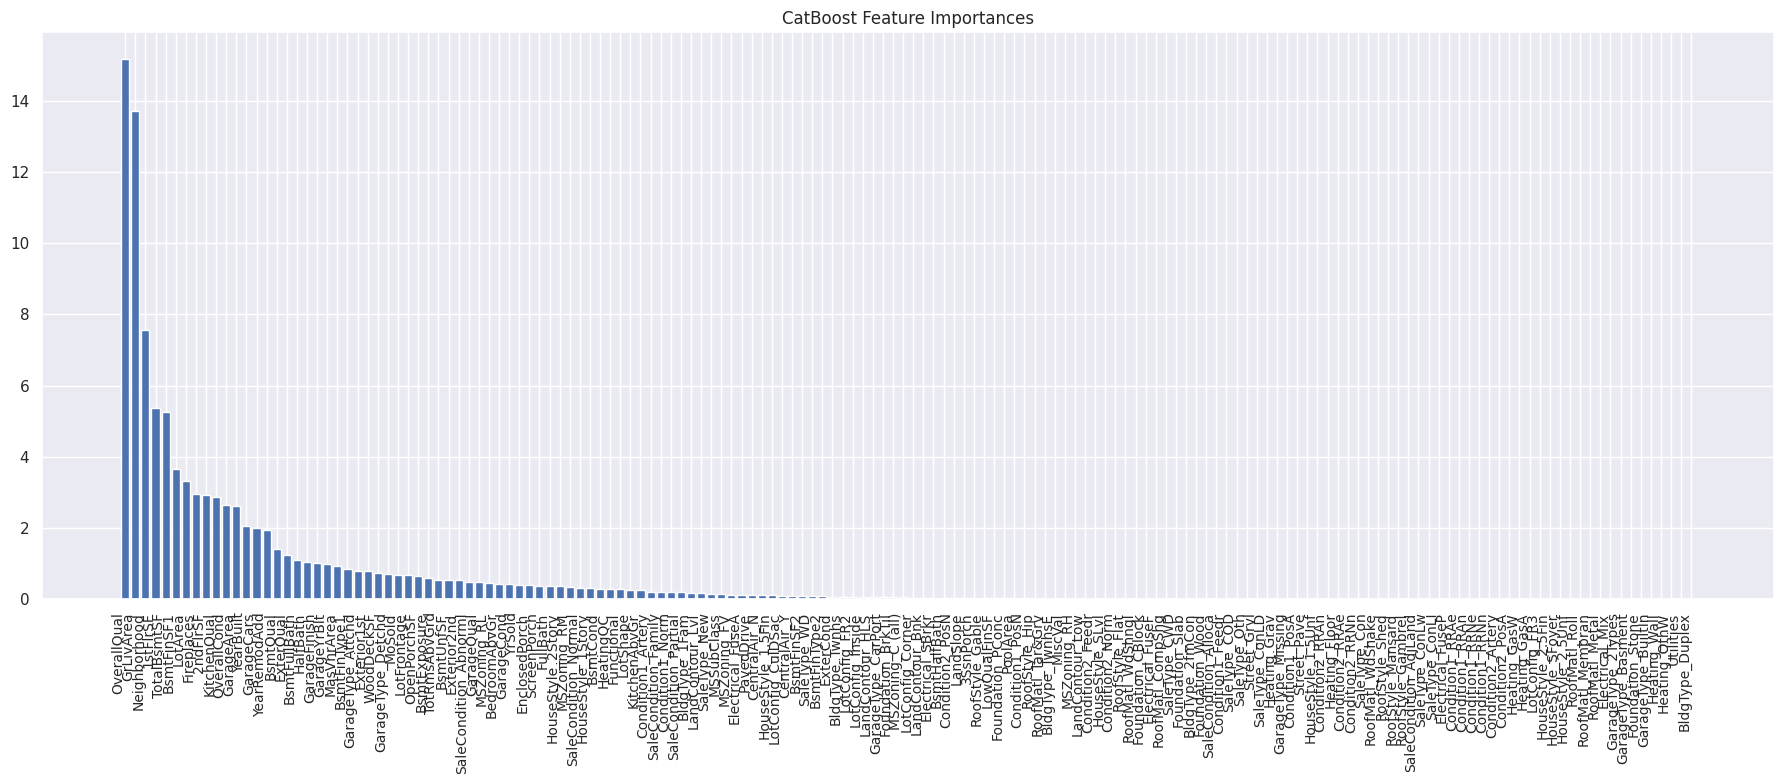

In [ ]:
# Строим график важности признаков

# Получаем признаки из препроцессора
feature_names = get_feature_names(preprocessor)

# Получаем важности из CatBoost регрессора
importances = regressor.get_feature_importance()
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(18, 8))
plt.title("CatBoost Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(
    range(len(importances)),
    np.array(feature_names)[indices],
    rotation=90,
    ha="right",
    fontsize=10
)
plt.tight_layout()
plt.show()


**Основные выводы:**

Наиболее важные признаки: OverallQual (качество построения и материала), Neighborhood (район), TotalBsmtSF (площадь подвала).

Средней важности: Fireplaces (камин), KitchenQual (качество кухни), GarageCars (количество автомобилей в гараже).

Многие признаки имеют низкую важность (например, Heating, Street), их можно было бы удалить из модели.

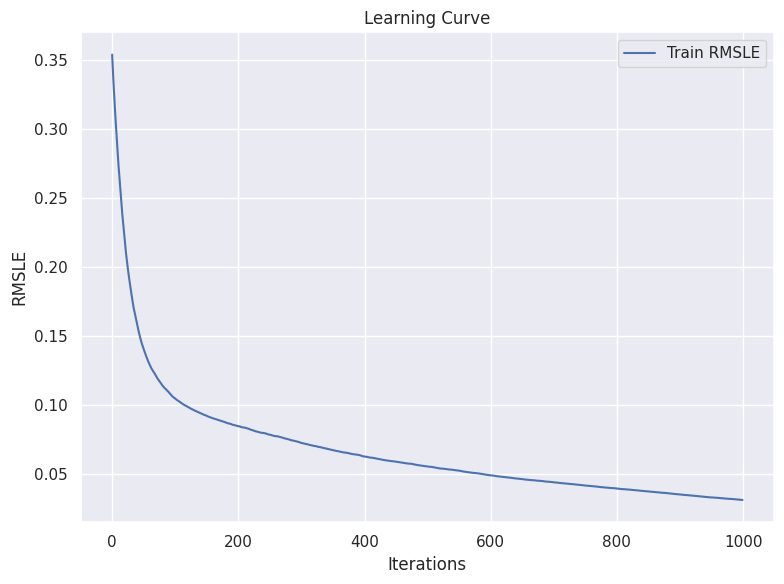

In [ ]:
# Строим график, который показывает динамику RMSLE на обучающей выборке по мере роста числа итераций (деревьев в бустинге)
history = regressor.get_evals_result()
train_scores = history['learn']['RMSE']
iters = list(range(len(train_scores)))

plt.figure(figsize=(8, 6))
plt.plot(iters, train_scores, label='Train RMSLE')
plt.xlabel("Iterations")
plt.ylabel("RMSLE")
plt.title("Learning Curve")
plt.legend()
plt.tight_layout()
plt.show()

**Вывод:** Модель быстро обучается и хорошо подгоняется под обучающую выборку — RMSLE стабильно снижается до ≈0.03. Однако после ~200 итераций улучшения становятся минимальными, что указывает на эффект затухающей отдачи. Тем не менее явного переобучения на графике не наблюдается.

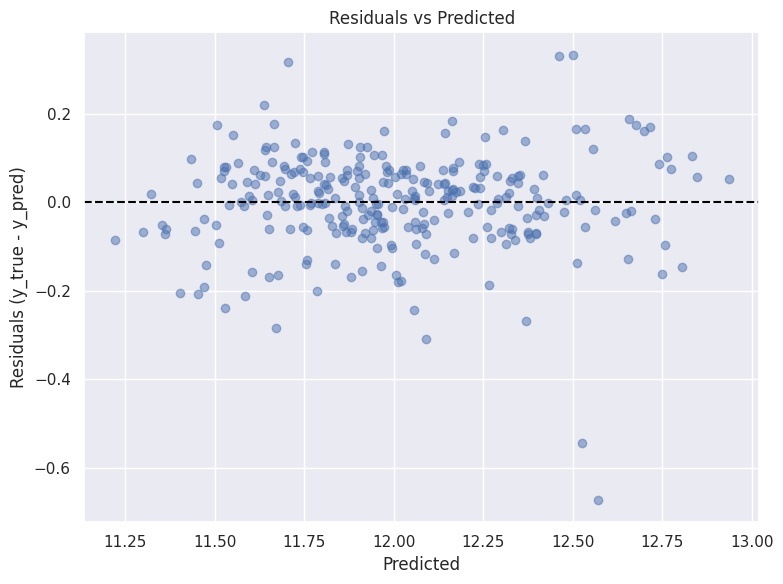

In [ ]:
# Строим график остатков на тестовой выборке
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals (y_true - y_pred)")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()

**Основные выводы:**

Остатки распределены относительно равномерно вокруг нулевой линии, но есть выбросы, картина для домов с низкой стоимостью и высокой выглядит весьма хаотично. Вероятно так могло получиться, потому что таких домов не много и модель не научилилась грамотно делать на них предсказания.


 98%|===================| 279/286 [00:19<00:00]       

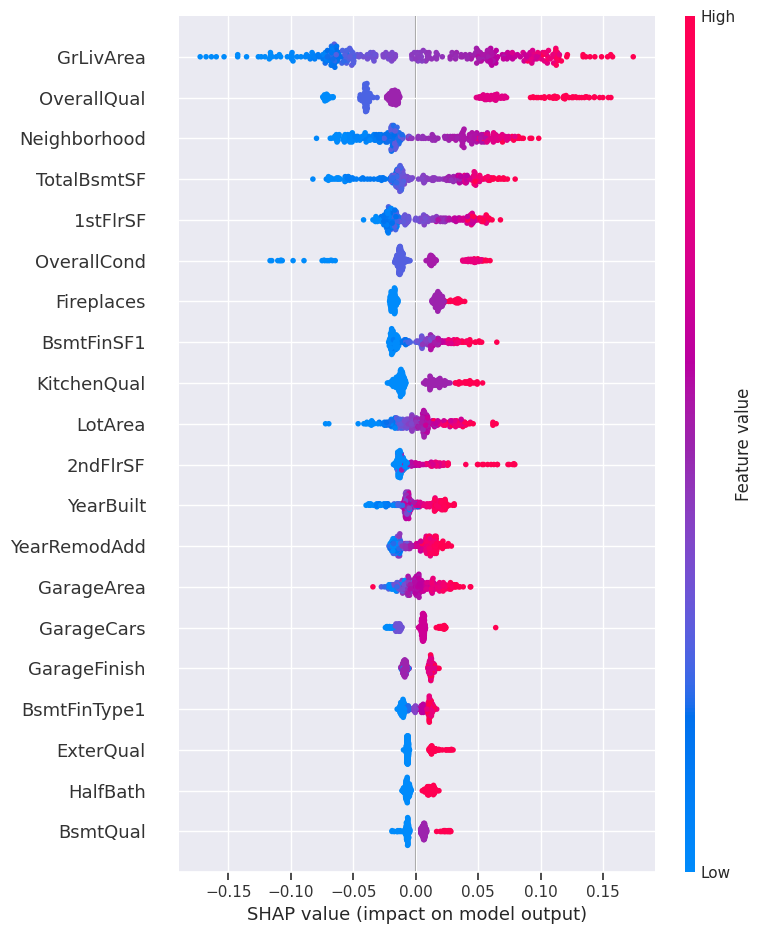

In [ ]:
# Строим SHAP-график

# 1. Извлекаем препроцессор и модель отдельно
preprocessor = best_model.named_steps['preprocessing']
model = best_model.named_steps['regressor']

# 2. Получаем имена признаков после трансформации
feature_names = get_feature_names(preprocessor)

# 3. Применяем препроцессинг
X_test_transformed = pd.DataFrame(preprocessor.transform(X_test), columns=feature_names)

# 4. Объясняем модель, а не pipeline
explainer = shap.Explainer(model, X_test_transformed)

# 5. Вычисляем значения SHAP и строим график
shap_values = explainer(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed)

На этом SHAP‑графике по горизонтали отложено влияние каждого признака на предсказанную цену (SHAP‑значение), а по вертикали — сами признаки, отсортированные по их «важности» (суммарному абсолютному влиянию). Цвет точек показывает уровень признака от низкого (синий) до высокого (красный).

**Выводы:**

Ключевые движущие факторы — жилая площадь (особенно над землёй), качество дома и район.

Больший размер дома, свежий ремонт/постройка, качественные материалы и дополнительные удобства (гараж, камины) усиливают предсказанную цену.

Низкие значения этих признаков однозначно «тянут» цену вниз.

## Получение предсказаний

In [ ]:
# Загружаем датасэт для тестирования и прогоняем его через target_encoder
X_submission = pd.read_csv('test.csv').set_index('Id')[all_cols]
X_submission[target_encoded_cols] = target_encoder.transform(X_submission[target_encoded_cols])

In [ ]:
# Получаем предсказния и применяем к ним экспоненту (така как предсказвали логарифм цены домы)
predictions = np.expm1(best_model.predict(X_submission))

In [ ]:
# Собираем файл
submission_df = pd.DataFrame({
    'Id': X_submission.index,
    'SalePrice': predictions
})

# Сохраняем
submission_df.to_csv('submission.csv', index=False)

Получили результат на kaggle: **RMSLE = 0.13518**

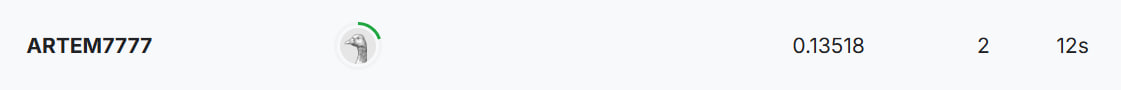